# Preparing data


### Imports

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm

In [ ]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 400)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

### Custom functions

In [ ]:
custom_palette_6 = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#17becf",  # Teal/Cyan
]

In [ ]:
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE


random_state = np.random.RandomState(42)


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000, axis=1)
        return X


en = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=42)

pipe = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("select_k_best", SelectKBest(chi2, k=1000)),
        ("select_forest", SelectFromModel(en, threshold=0.001, max_features=250)),
        ("standard_scale", StandardScaler()),
    ]
)
le = LabelEncoder()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def multiclass_roc_auc_score(y_test, y_pred, average="macro") -> float:
    """Returns averaged auc per class"""
    unique_classes = set(y_test)
    roc_auc_dict = {}

    for tested_class in unique_classes:
        other_classes = [x for x in unique_classes if x != tested_class]

        # Mark the current class as 1 and all other classes as 0
        binary_y_test = [0 if x in other_classes else 1 for x in y_test]
        binary_y_pred = [0 if x in other_classes else 1 for x in y_pred]

        roc_auc = roc_auc_score(binary_y_test, binary_y_pred, average=average)

        roc_auc_dict[tested_class] = roc_auc

    return sum(roc_auc_dict.values()) / len(roc_auc_dict.values())


def make_score(y_test, y_pred) -> zip:
    accuracy, precision, recall, f1, roc_auc = (
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro", zero_division=np.nan),
        recall_score(y_test, y_pred, average="macro", zero_division=np.nan),
        f1_score(y_test, y_pred, average="macro", zero_division=np.nan),
        multiclass_roc_auc_score(y_test, y_pred),
    )

    score_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
    return zip(score_names, (accuracy, precision, recall, f1, roc_auc))


def get_confusion_matrix(test_pred, y_test, name):
    fig, ax = plt.subplots(figsize=(8, 8))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        test_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        values_format=".0%",
    )

    ax.set_title(f"Confusion Matrix {name}")
    plt.tight_layout()
    save_fig(f"Confusion_Matrix_{name}")
    plt.show()

In [ ]:
from pathlib import Path
from datetime import datetime

p = Path().cwd().parent
date = datetime.today().strftime("%Y%m%d")[2:]  # Get shortened year

IMAGES_PATH = p / f"{date}_output"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    """Save figure in png."""
    path = IMAGES_PATH / f"{fig_name}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Import counts

In [ ]:
file_name = "/home/t.afanasyeva/MAT_rnaseq/resources/250605_all_dfs.txt"
data = pd.read_csv(file_name, sep="\t", header=1, index_col="Geneid")

print(data.shape)
data.sample(1)

Clean names of df columns for mapping

In [ ]:
columns = list(data.columns)

new_columns = []
for column in columns:
    new_column = column.split("/")[1].split(".")[0]
    new_columns.append(new_column)

data.columns = new_columns
data.head(1)

Map names of the samples to the IDs and check if all samples mapped correctly

In [ ]:
path_names = "/home/t.afanasyeva/MAT_rnaseq/resources/sample_names.csv"
names = pd.read_csv(path_names, sep=",")
mapping_dict = dict(zip(names["sample_id"], names["sample_name"]))
data = data.rename(columns=mapping_dict)
data = data.T
data = data[~data.index.duplicated(keep="last")]
data = data[data.index.notnull()]

In [ ]:
data.sort_index(inplace=True)
data.head(10)

Filter the data to exclude samples with read counts lower than 1 million

In [29]:
mask = data.sum(axis=1) > 1000000
data = data[mask]

data.index.name = "samples"
data.reset_index(inplace=True)
data.set_index("samples", inplace=True)

Experiment MD104 is excluded due to wrong concentrations being sent


In [30]:
data = data[~data.index.str.contains("MD104")]

Sample MD215_7115_IMDM_3 is excluded due to low input concentration being sent



In [31]:
data = data.loc[data.index != "MD215_7115_IMDM_3"]  # Drop for low input concentration

## Analysing the data for outliers

In [32]:
def to_normalize_rpm(df):
    # Normalise the gene counts to the library size
    df = df.apply(
        lambda x: (x / (np.sum(x) if np.sum(x) != 0 else 1)) * 1000000, axis=1
    )  # Normalise to the size of the library and recalculate in rpm
    return df


df = to_normalize_rpm(data.copy())
il6 = df["IL6"].to_frame()

Check the expression levels of IL6 gene in each class

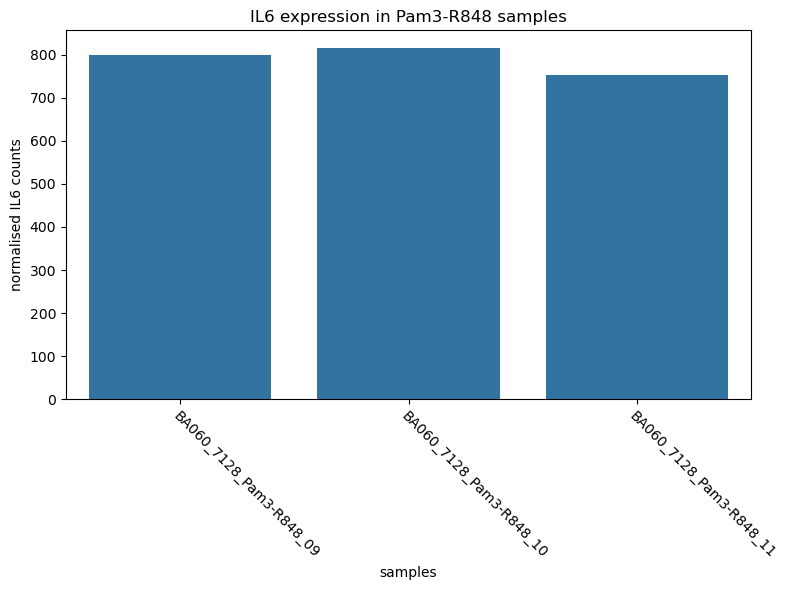

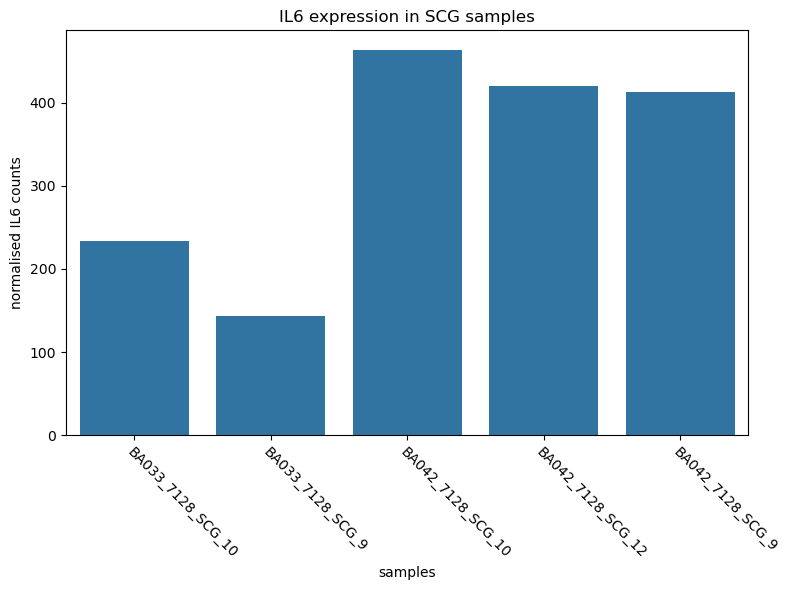

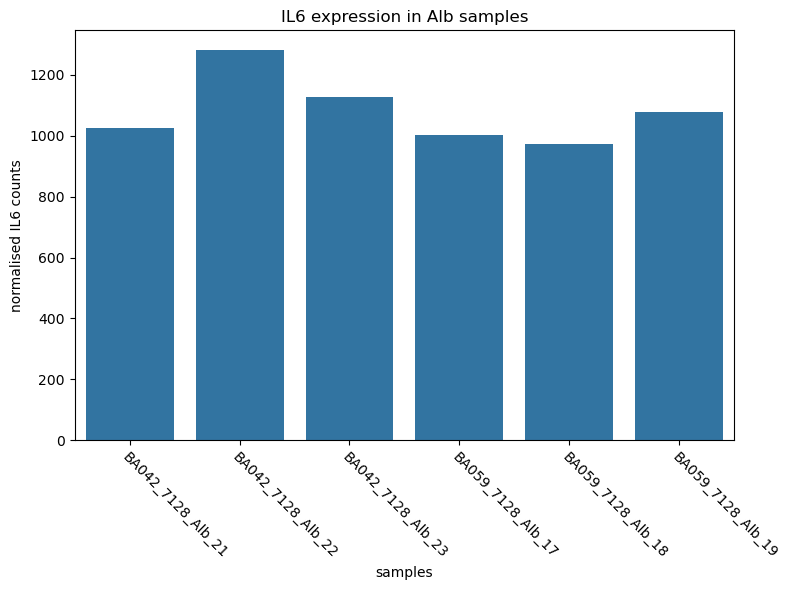

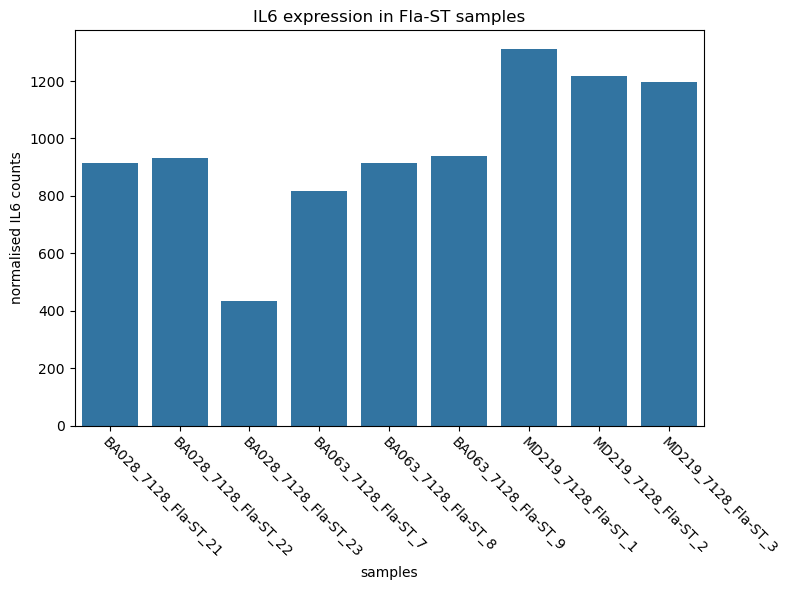

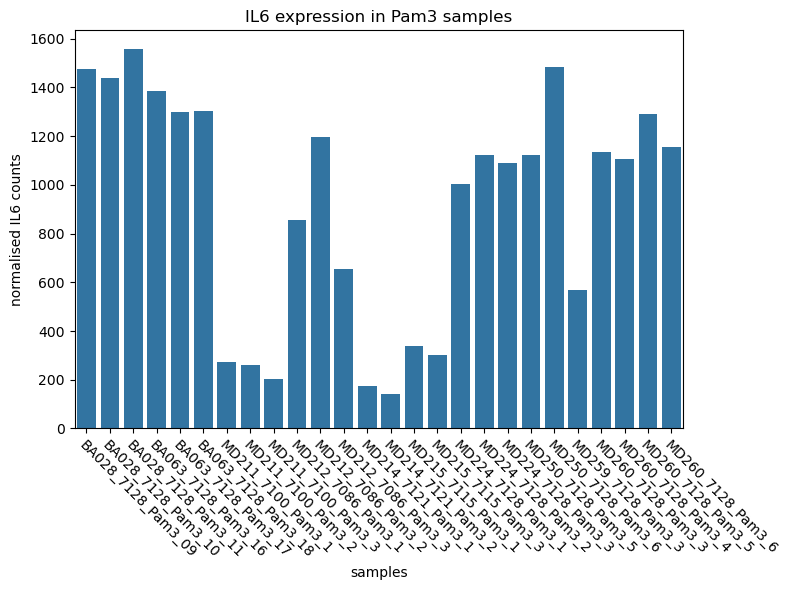

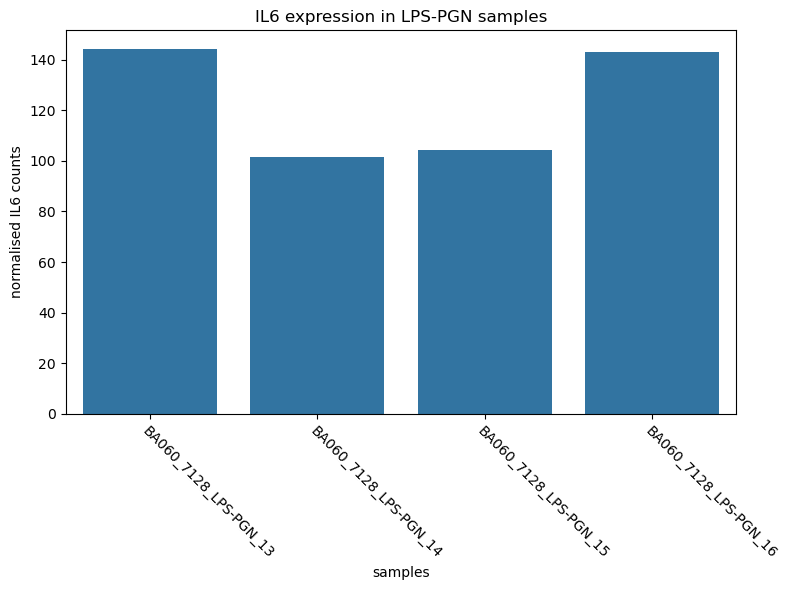

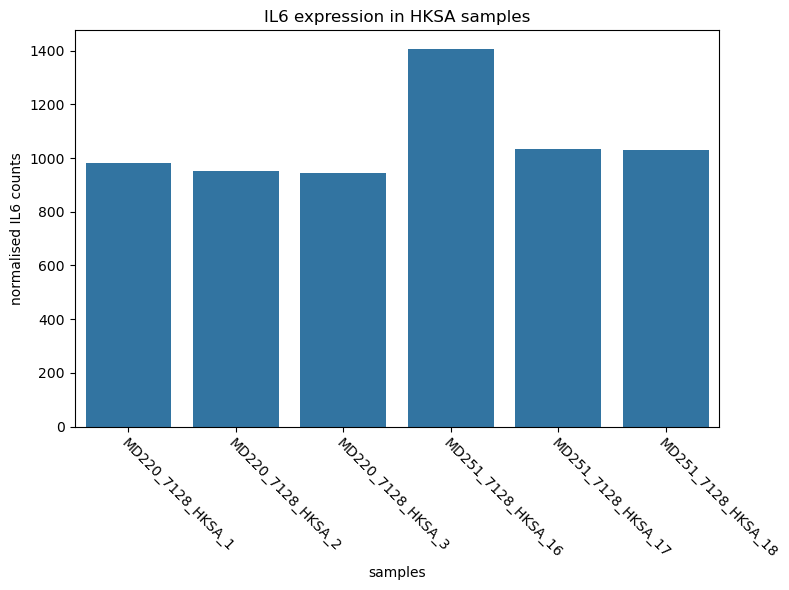

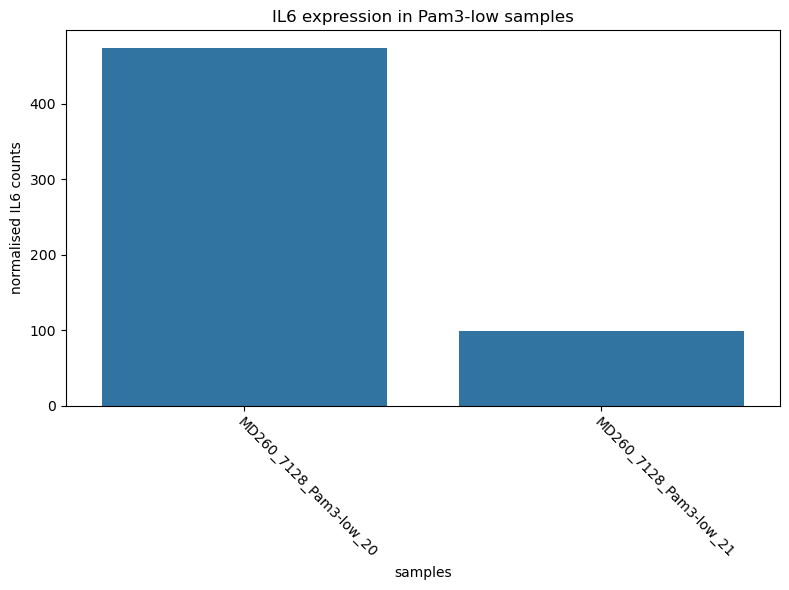

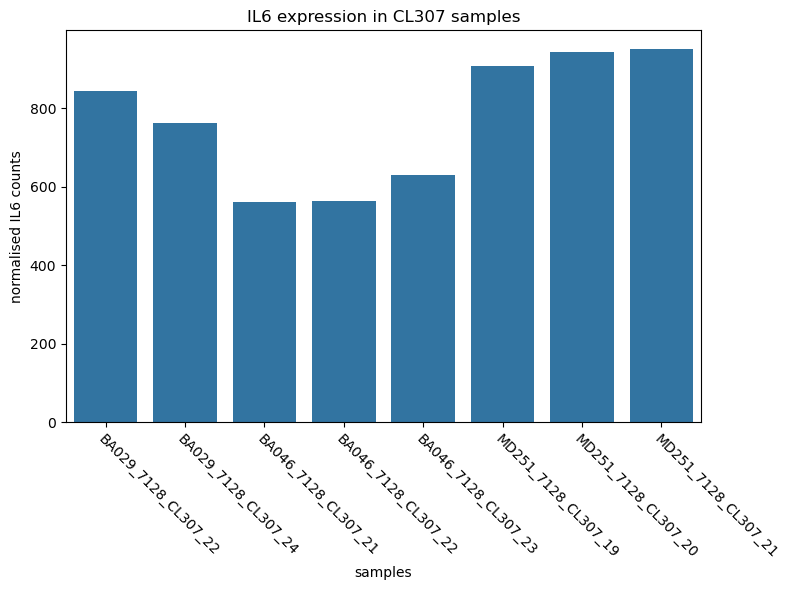

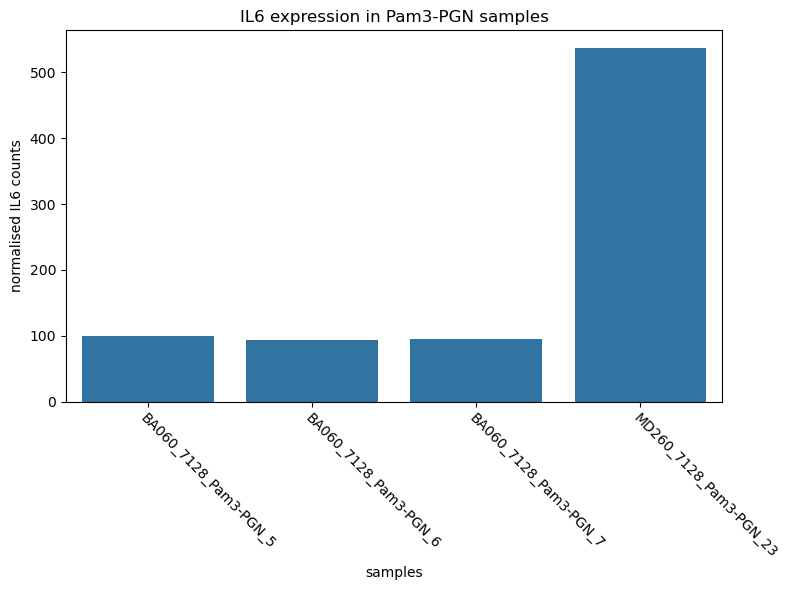

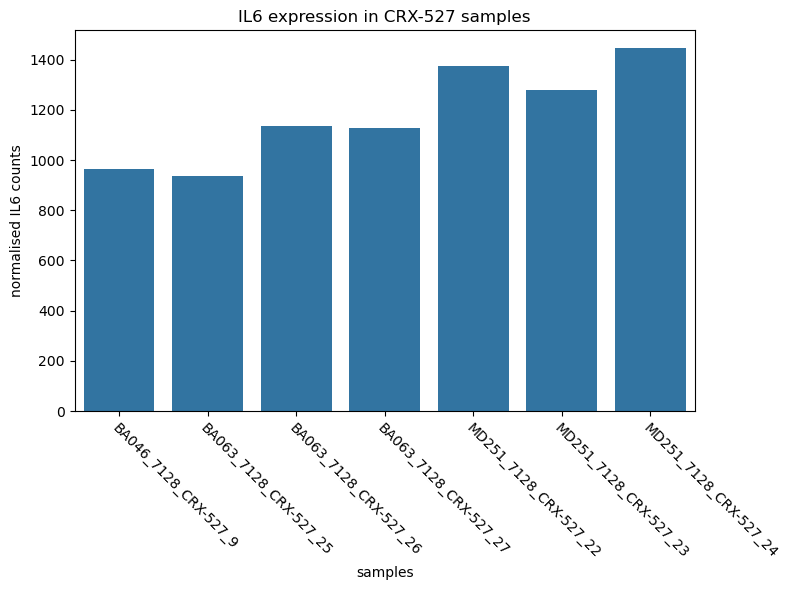

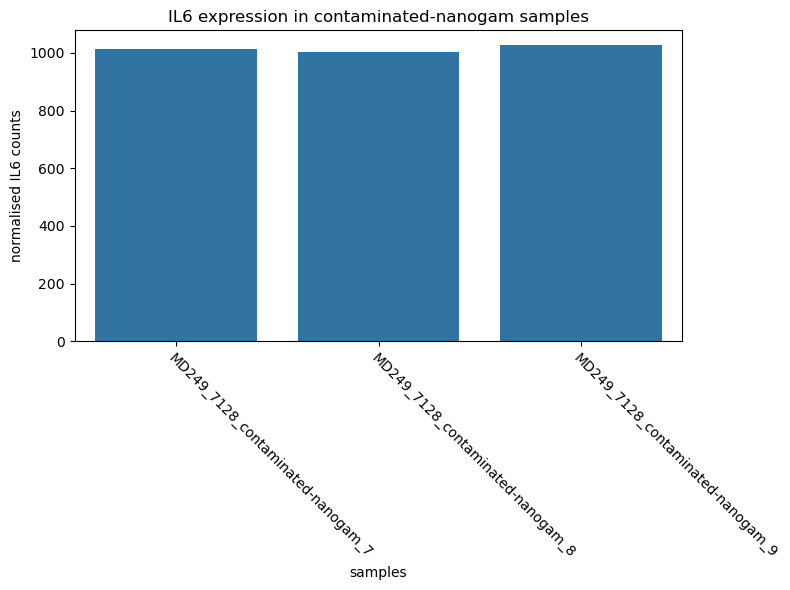

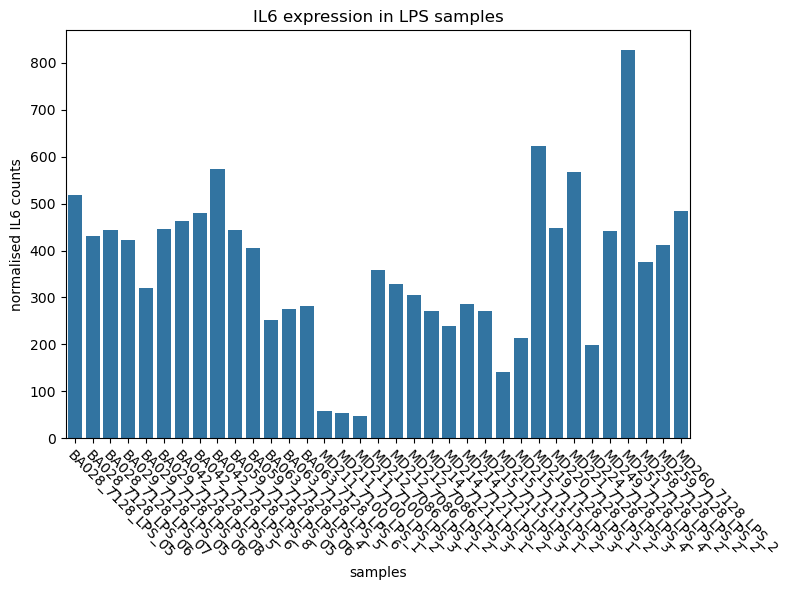

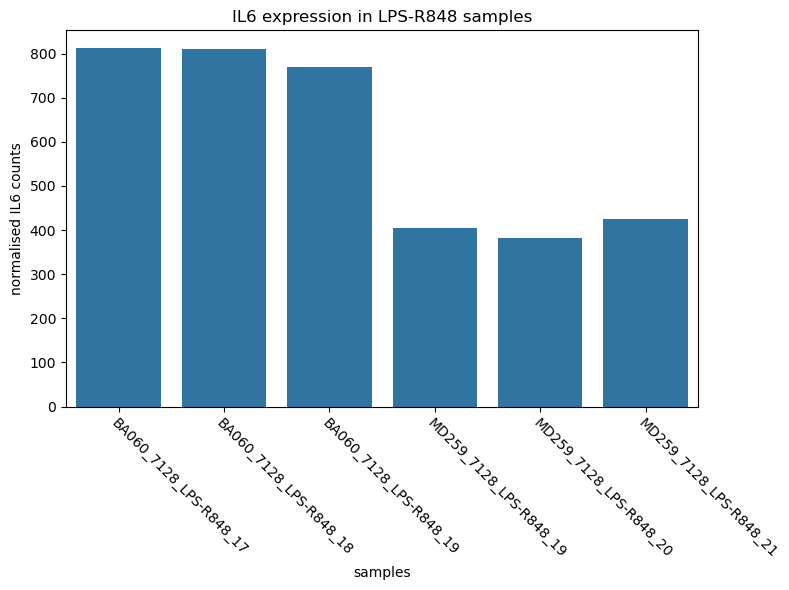

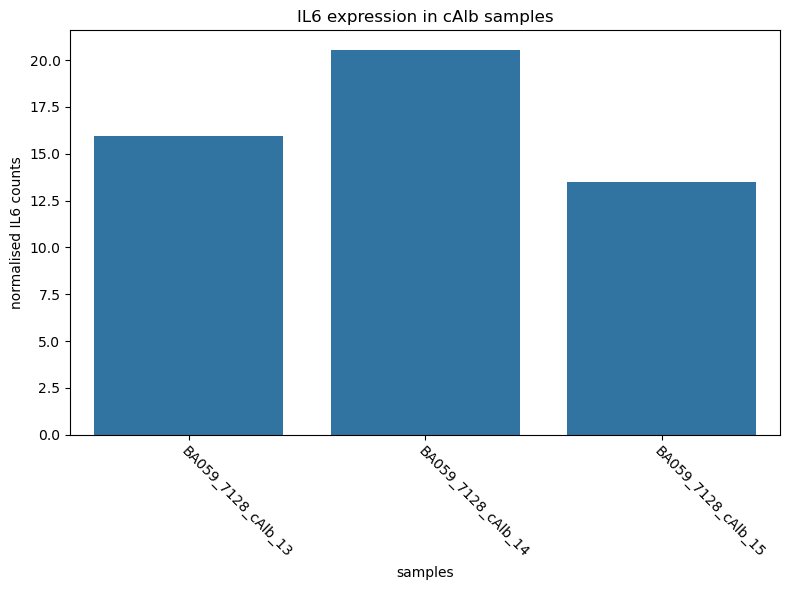

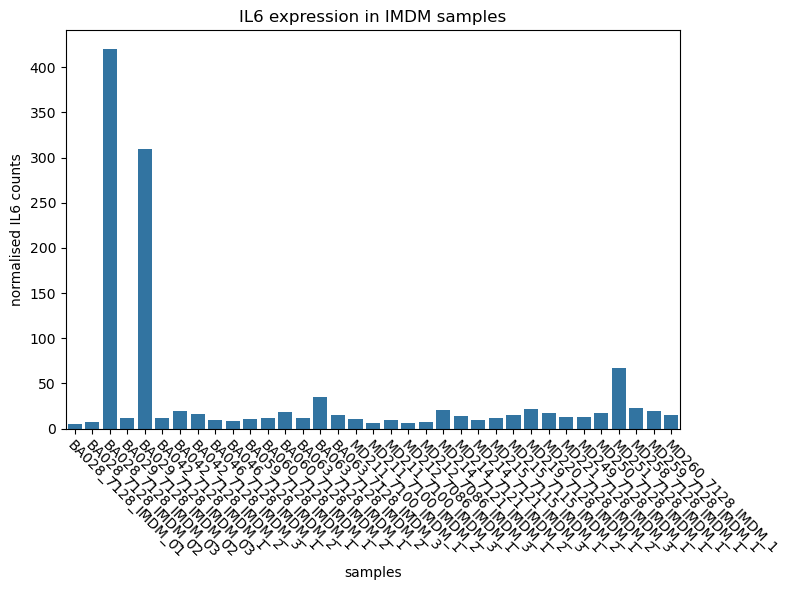

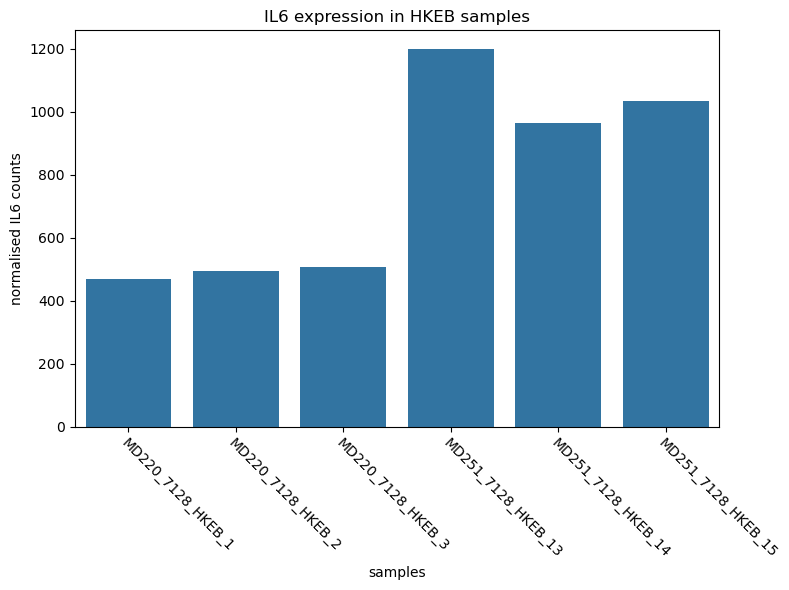

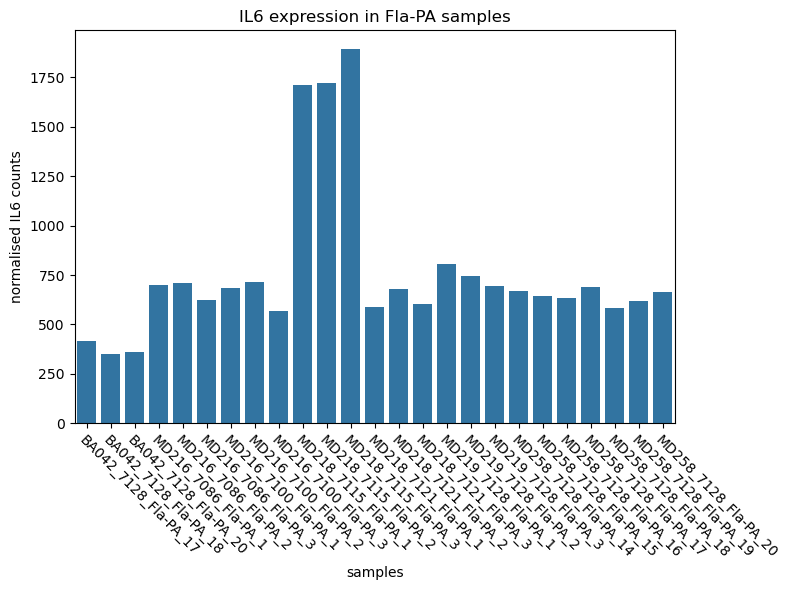

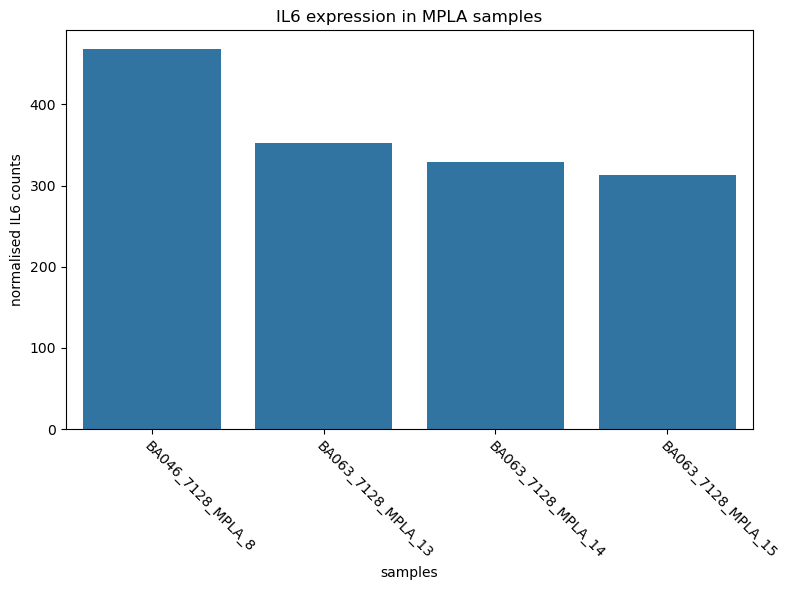

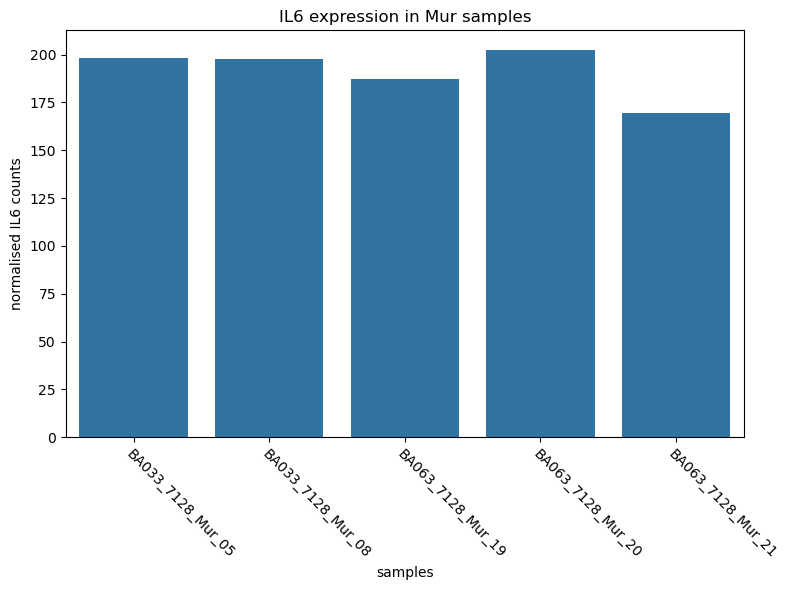

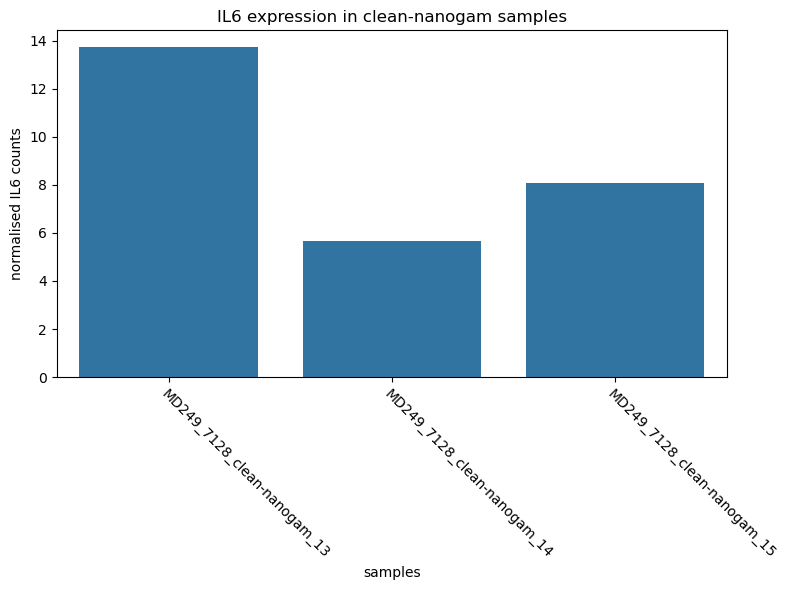

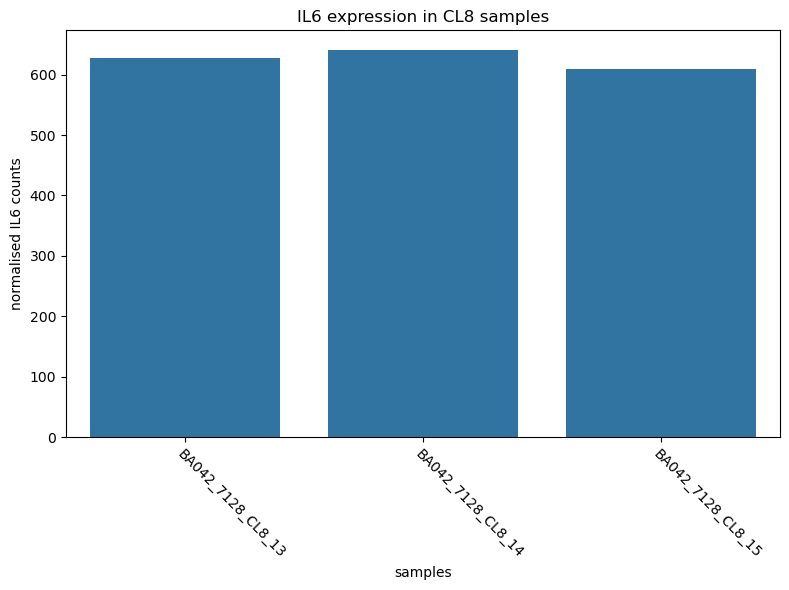

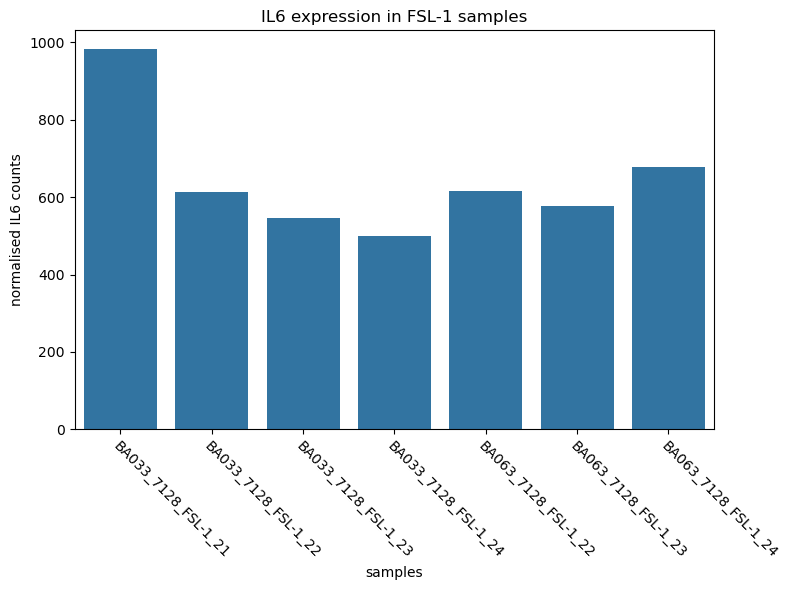

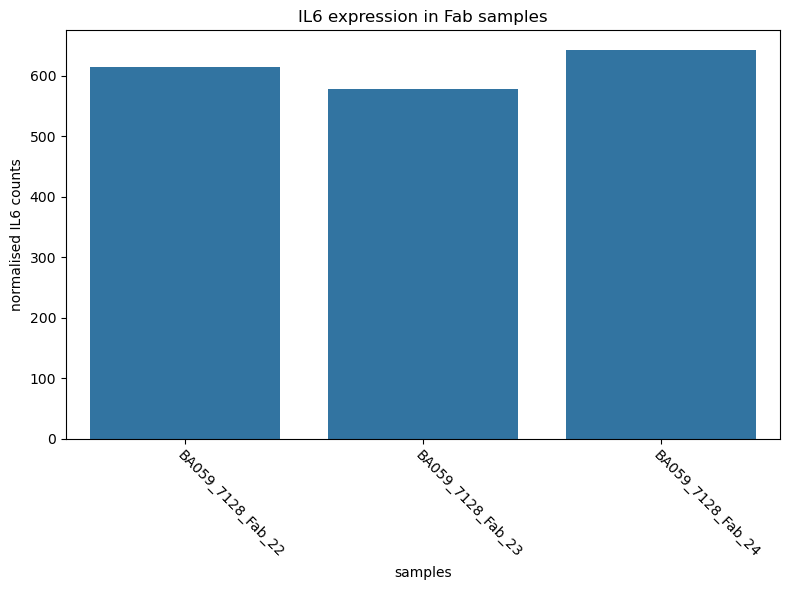

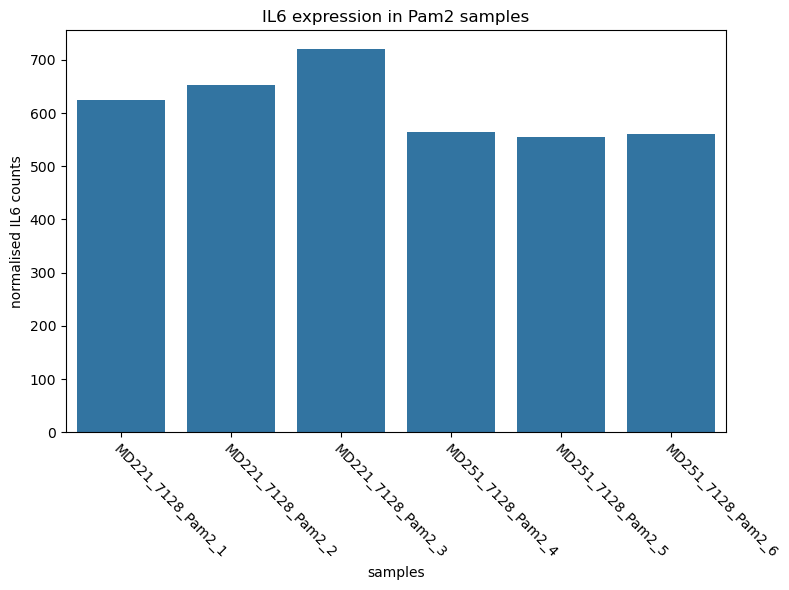

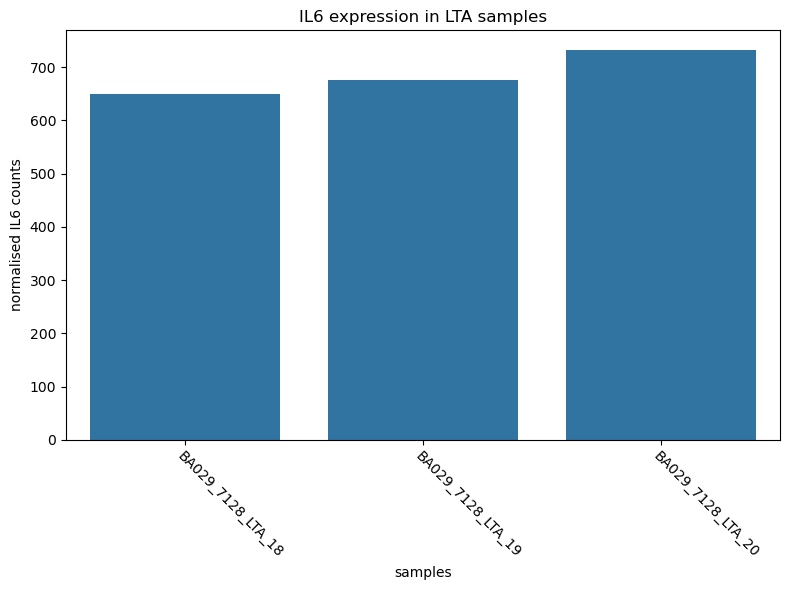

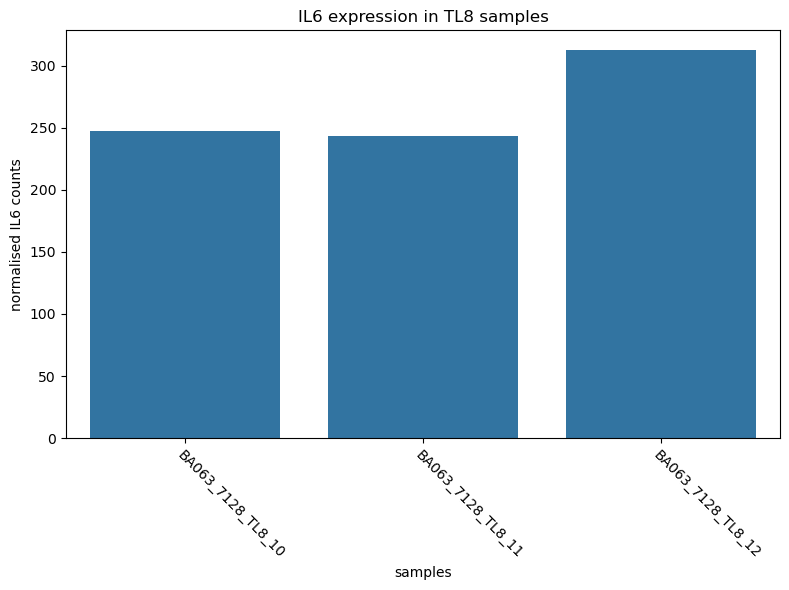

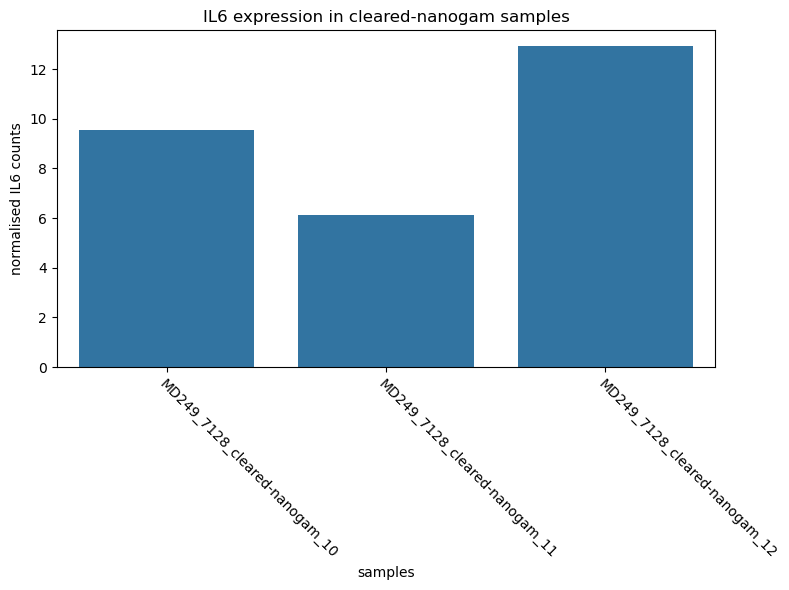

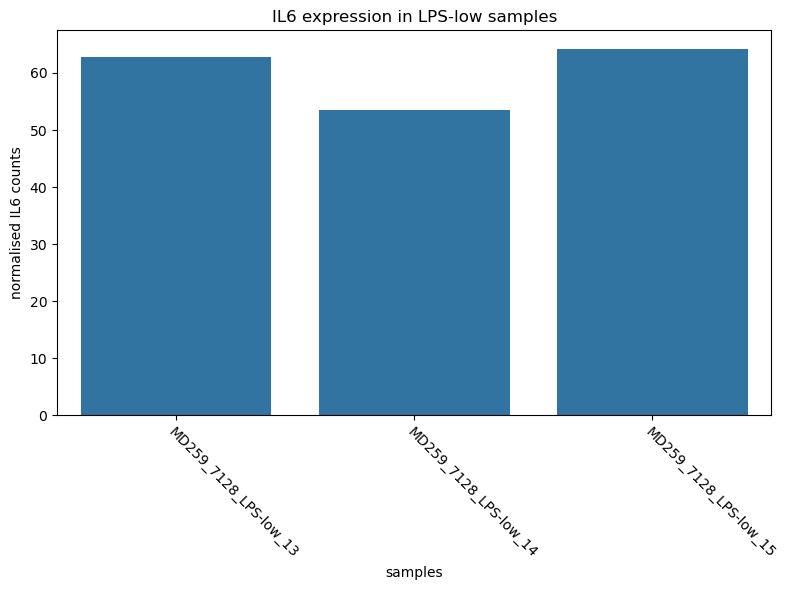

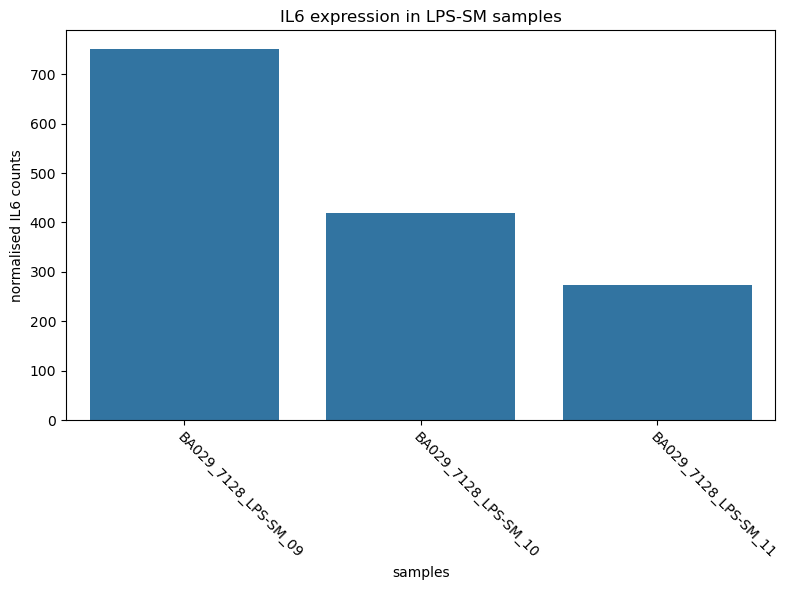

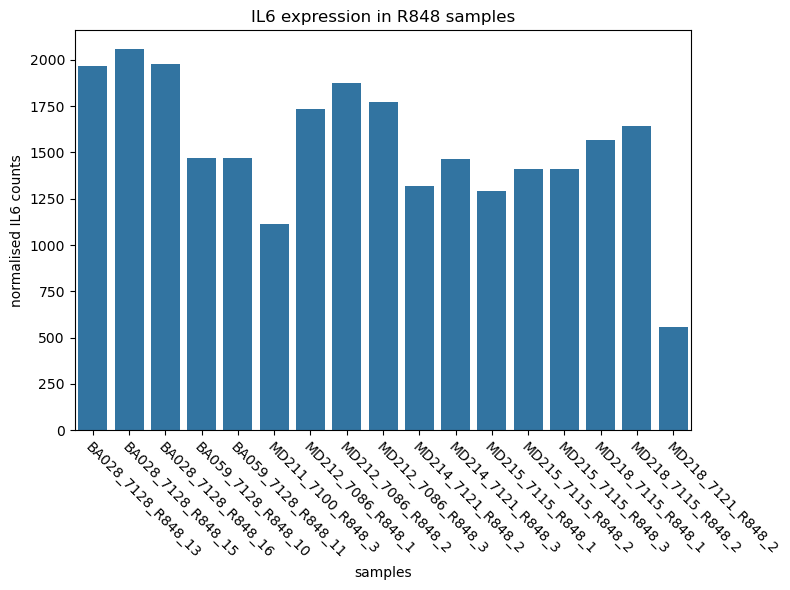

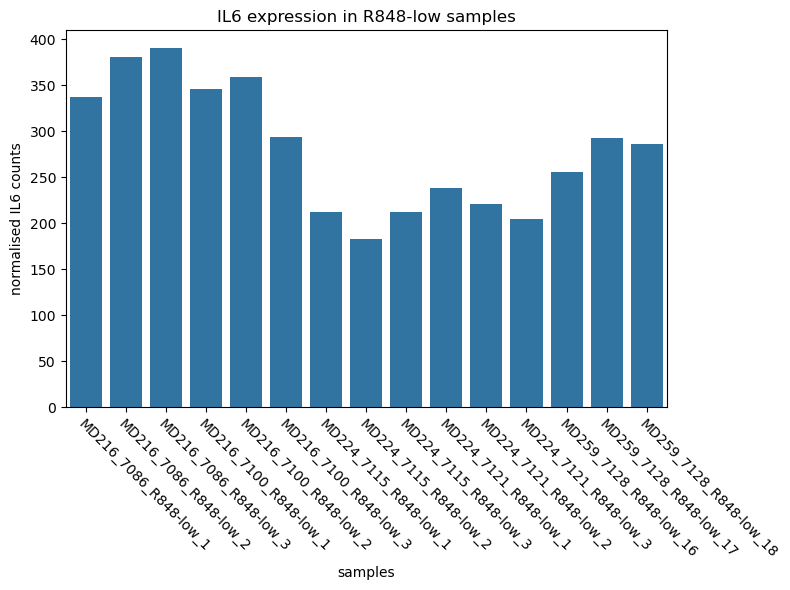

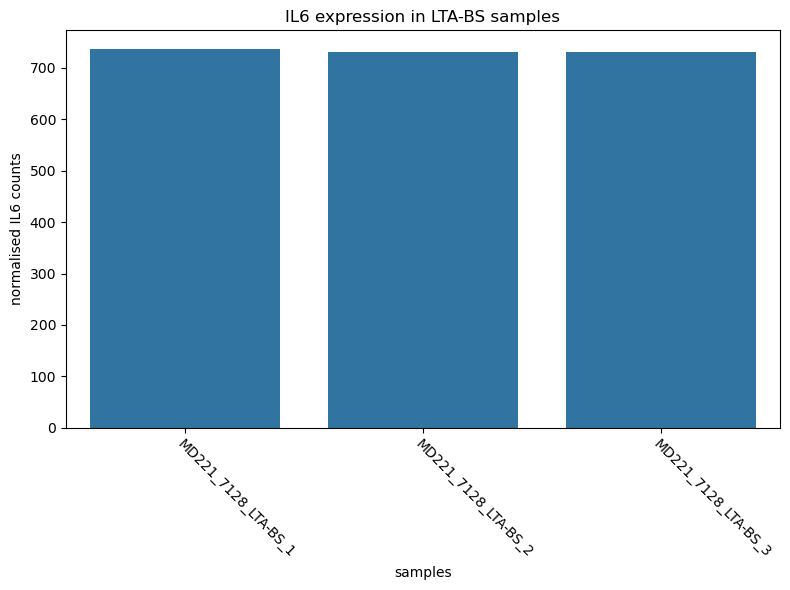

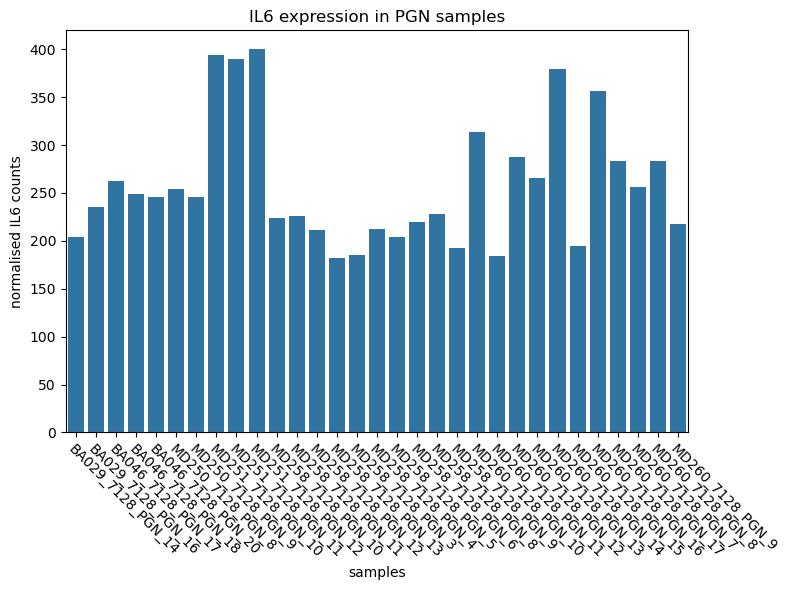

In [ ]:
for ligand_class in set("_" + il6.index.str.split("_").str[2] + "_"):
    fig, ax = plt.subplots(figsize=(8, 6))
    il6_of_ligand_class = il6[il6.index.str.contains(ligand_class)]
    ax = sns.barplot(
        x=il6_of_ligand_class.index,
        y="IL6",
        data=il6_of_ligand_class.sort_values(by="samples"),
    )
    ax.set_xticks(np.arange(len(il6_of_ligand_class.index)))
    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
    )
    ax.set(ylabel="normalised IL6 counts", xlabel="samples")
    plt.title(f'IL6 expression in {ligand_class.strip("_")} samples')
    save_fig(f"Class: {ligand_class}")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

High levels in IMDM class signify contamination or sample swap

/tmp/ipykernel_2052465/2071094346.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(il6[["_IMDM_" in s for s in il6.index]][il6["IL6"] > 25])


                          IL6
samples                      
BA028_7128_IMDM_03  419.96931
BA029_7128_IMDM_03  309.04284
BA063_7128_IMDM_2    35.14130
MD251_7128_IMDM_1    66.89236


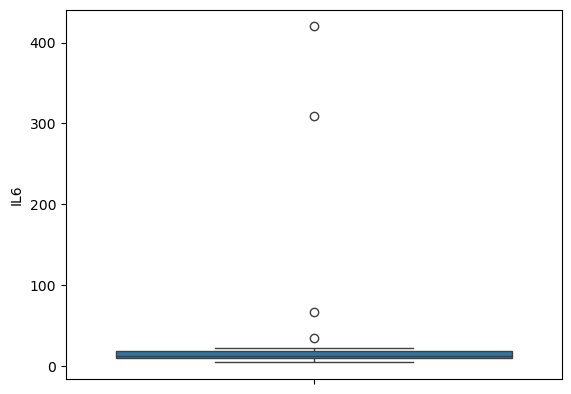

In [65]:
print(il6[["_IMDM_" in s for s in il6.index]][il6["IL6"] > 25])
sns.boxplot(il6[["_IMDM_" in s for s in il6.index]]["IL6"])

# Remove from the original data
data = data.loc[data.index != "BA029_7128_IMDM_03"]  # Drop for high il6 gene expresison
data = data.loc[data.index != "BA028_7128_IMDM_03"]  # Drop for high il6 gene expresison
data = data.loc[data.index != "MD251_7128_IMDM_1"]  # Drop for high il6 gene expresison
data = data.loc[
    data.index != "BA063_7128_IMDM_2"
]  # Drop for high il6 gene expresisonon

## PCA of all samples

In [66]:
labels = pd.DataFrame(index=data.index)
labels["label"] = [i.split("_")[2] for i in data.index]

In [68]:
processed_data = pipe.fit_transform(data, labels)
training_labels_int = le.fit_transform(labels["label"].to_numpy())
X_reduced = PCA(n_components=2).fit_transform(processed_data)

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


/tmp/ipykernel_2052465/873086949.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(path, format=fig_extension, dpi=resolution)


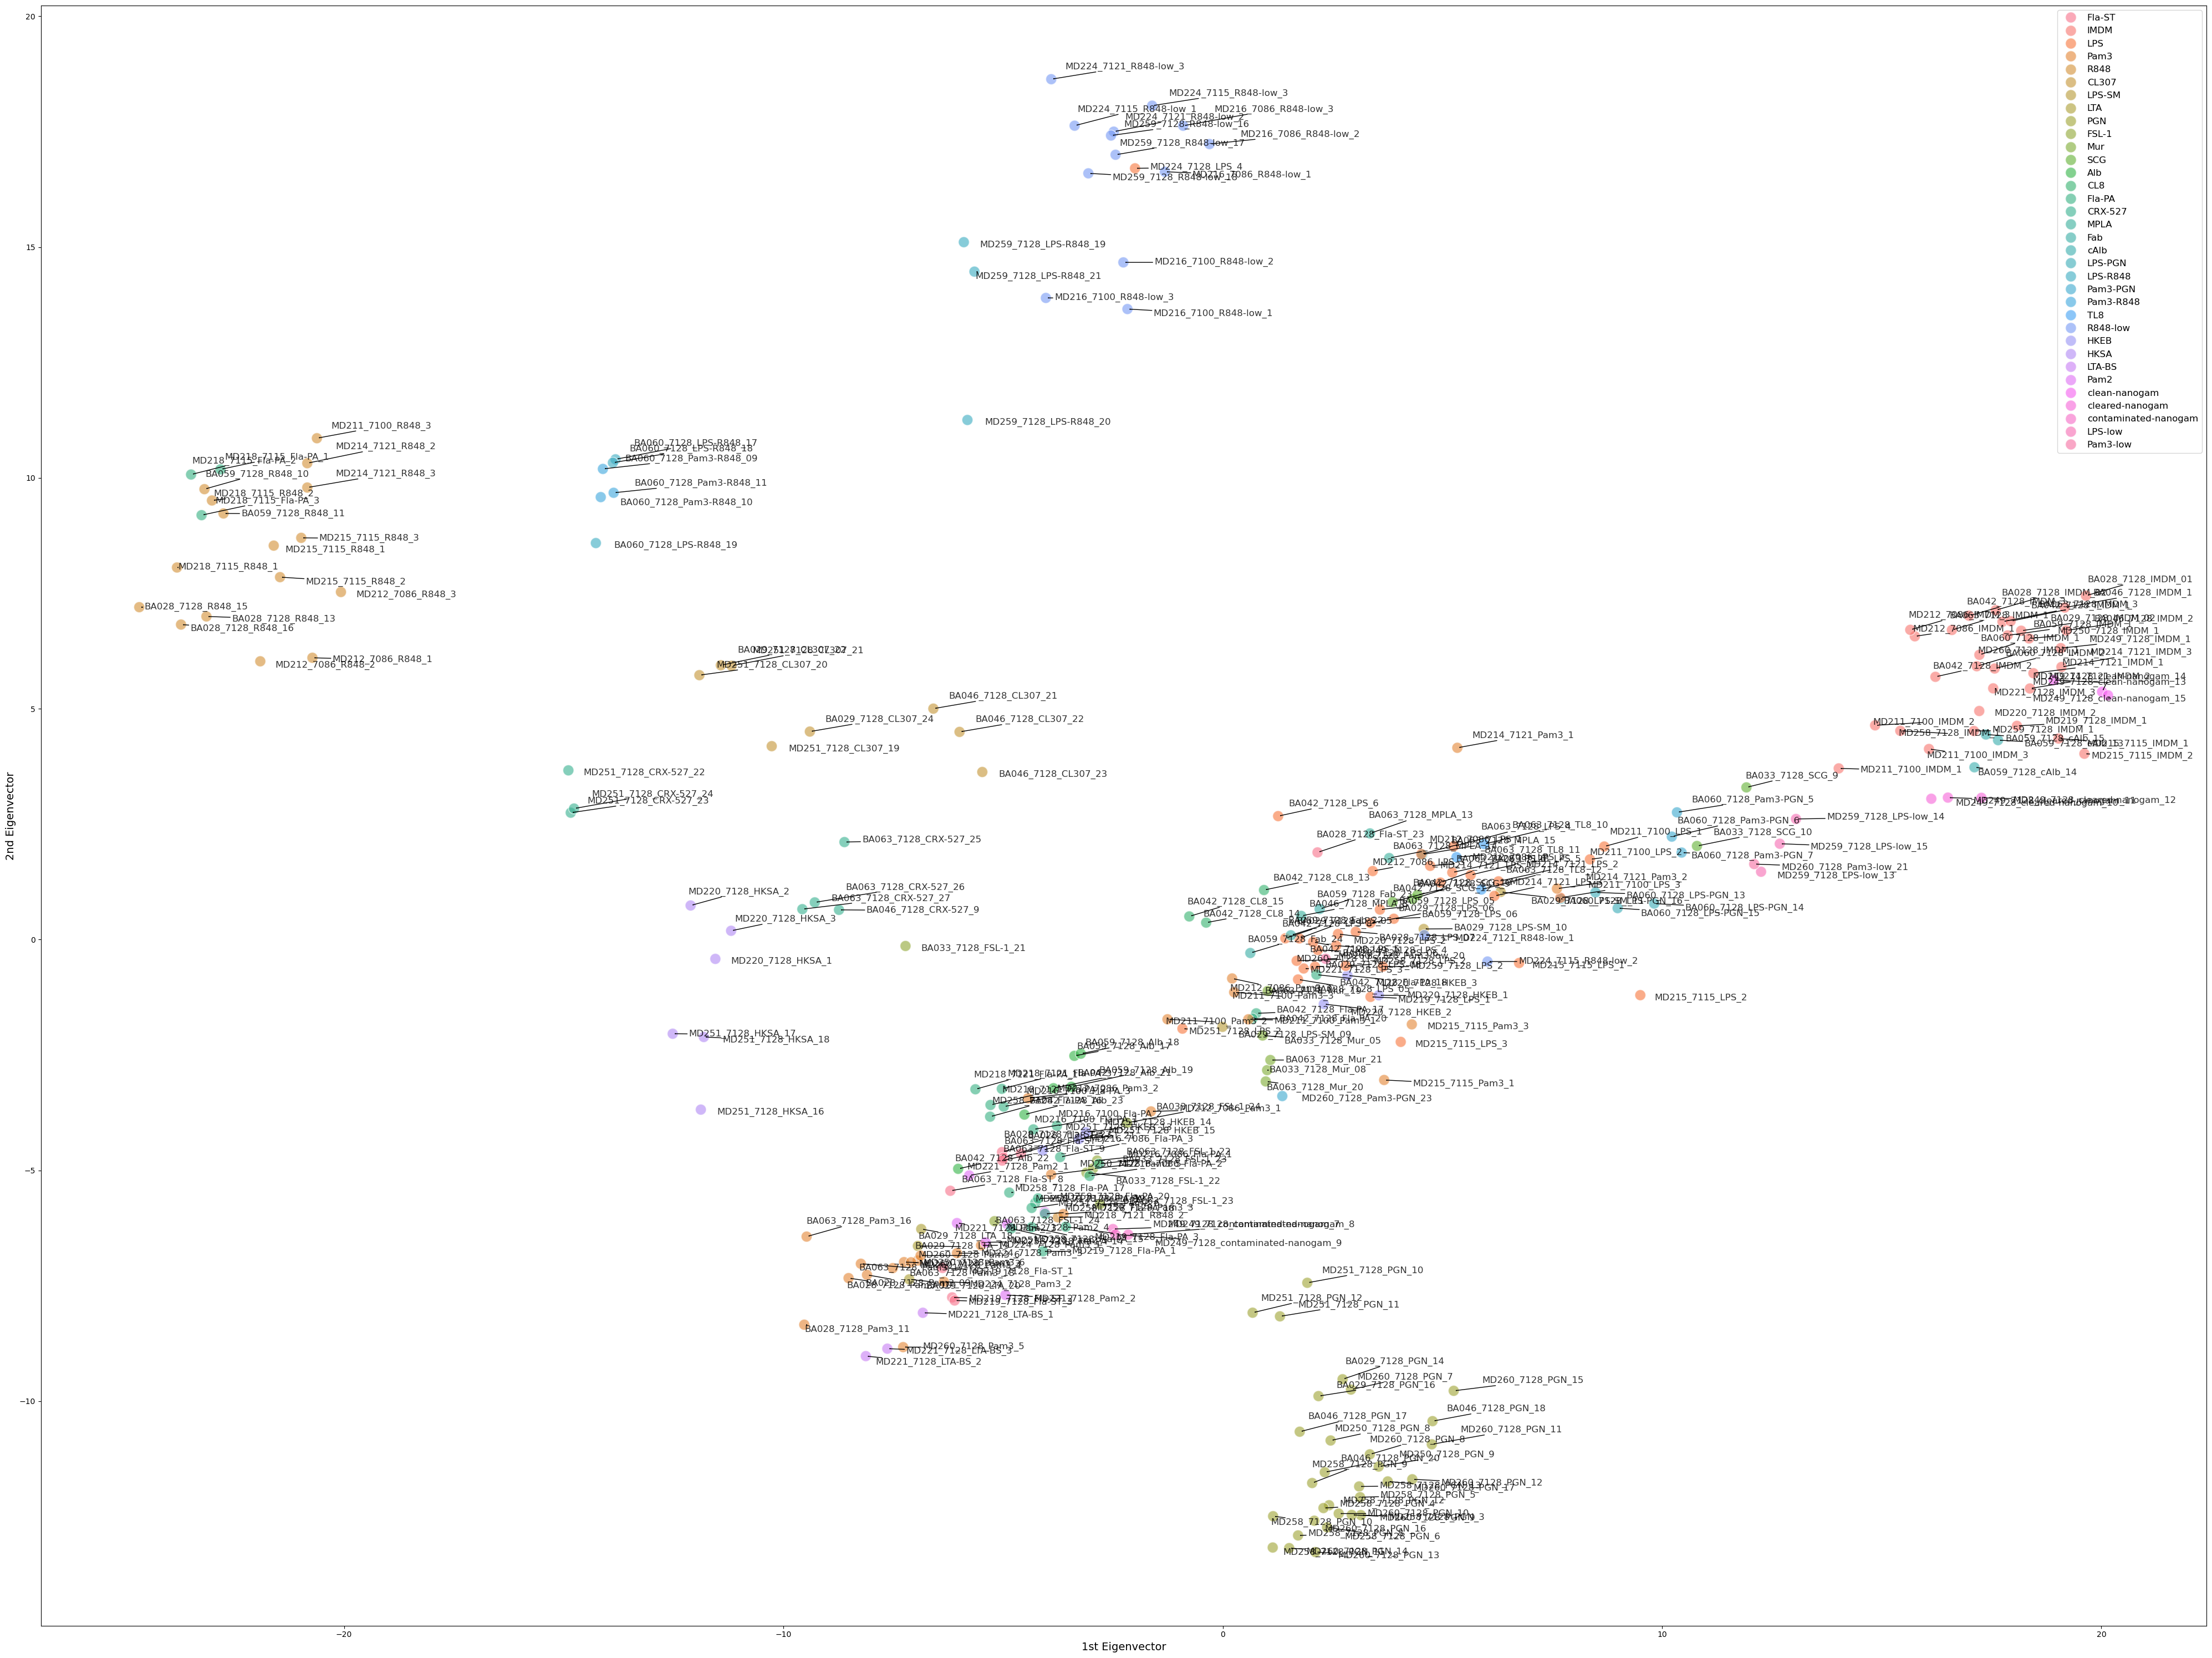

In [69]:
fig = plt.figure(figsize=(40, 30))
ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels["label"].to_numpy(),
    s=200,  # Increase dot size
    alpha=0.6,
)

texts = [
    ax.text(
        X_reduced[:, 0][i],
        X_reduced[:, 1][i],
        labels.index.to_numpy()[i],
        ha="left",
        va="bottom",
        alpha=0.8,
        fontsize=12,  # Increase font size
    )
    for i in range(len(X_reduced))
]

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector", fontsize=14)  # Increase font size
ax.set_ylabel("2nd Eigenvector", fontsize=14)  # Increase font size
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1, fontsize=12)  # Increase legend font size
save_fig("PCA_plot_all_data")
plt.tight_layout()
plt.show()

Dropping the MD224_7128_LPS_4 as it clusters with R848 likely due to a sample swap

In [89]:
data = data[
    ~data.index.isin(
        [
            "MD224_7128_LPS_4",
        ]
    )
]
data.shape

(300, 47698)

In [ ]:
# data.to_csv(
#     f"/home/t.afanasyeva/MAT_rnaseq/resources/250624_300.csv",
#     index="None",
# )

## Training batch 7128

In [ ]:
def prepare_training(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """Get training classes and labels dfs"""
    training_classes = [
        "_IMDM_",
        "_LPS_",
        "_Fla-PA_",
        "_PGN_",
        "_Pam3_",
        "_R848_",
    ]

    training_subset = [
        index
        for index, sample_id in enumerate(df.index)
        for c in training_classes
        if c in sample_id and "7128" in sample_id
    ]

    training_data = df.iloc[training_subset]

    labels = pd.DataFrame(index=training_data.index)
    labels["label"] = [i.split("_")[2] for i in training_data.index]

    return training_data, labels


training_data, training_labels = prepare_training(data)

In [92]:
training_data.shape, training_labels.shape, training_labels["label"].value_counts()

((108, 47698),
 (108, 1),
 label
 PGN       31
 LPS       22
 IMDM      21
 Pam3      16
 Fla-PA    13
 R848       5
 Name: count, dtype: int64)

14-01-2025 As per "Thinking in Pandas talk" I want to try multiindexed df here.

In [ ]:
# training_labels.reset_index(inplace=True)
# training_data.index = pd.MultiIndex.from_frame(
#     training_labels, names=["samples", "label"]
# )
# training_data.to_csv(
#     "/home/t.afanasyeva/MAT_rnaseq/resources/250624_training_multindex_108_7128.csv",
# )

In [ ]:
training_data = pd.read_csv(
    "/home/t.afanasyeva/MAT_rnaseq/resources/250624_training_multindex_108_7128.csv",
    index_col="samples",
)
training_labels = training_data.label.to_frame()
training_data.drop(columns=["label"], inplace=True)
training_data.shape, training_labels.shape, training_labels["label"].value_counts()

((108, 47698),
 (108, 1),
 label
 PGN       31
 LPS       22
 IMDM      21
 Pam3      16
 Fla-PA    13
 R848       5
 Name: count, dtype: int64)

### PCA on training data

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


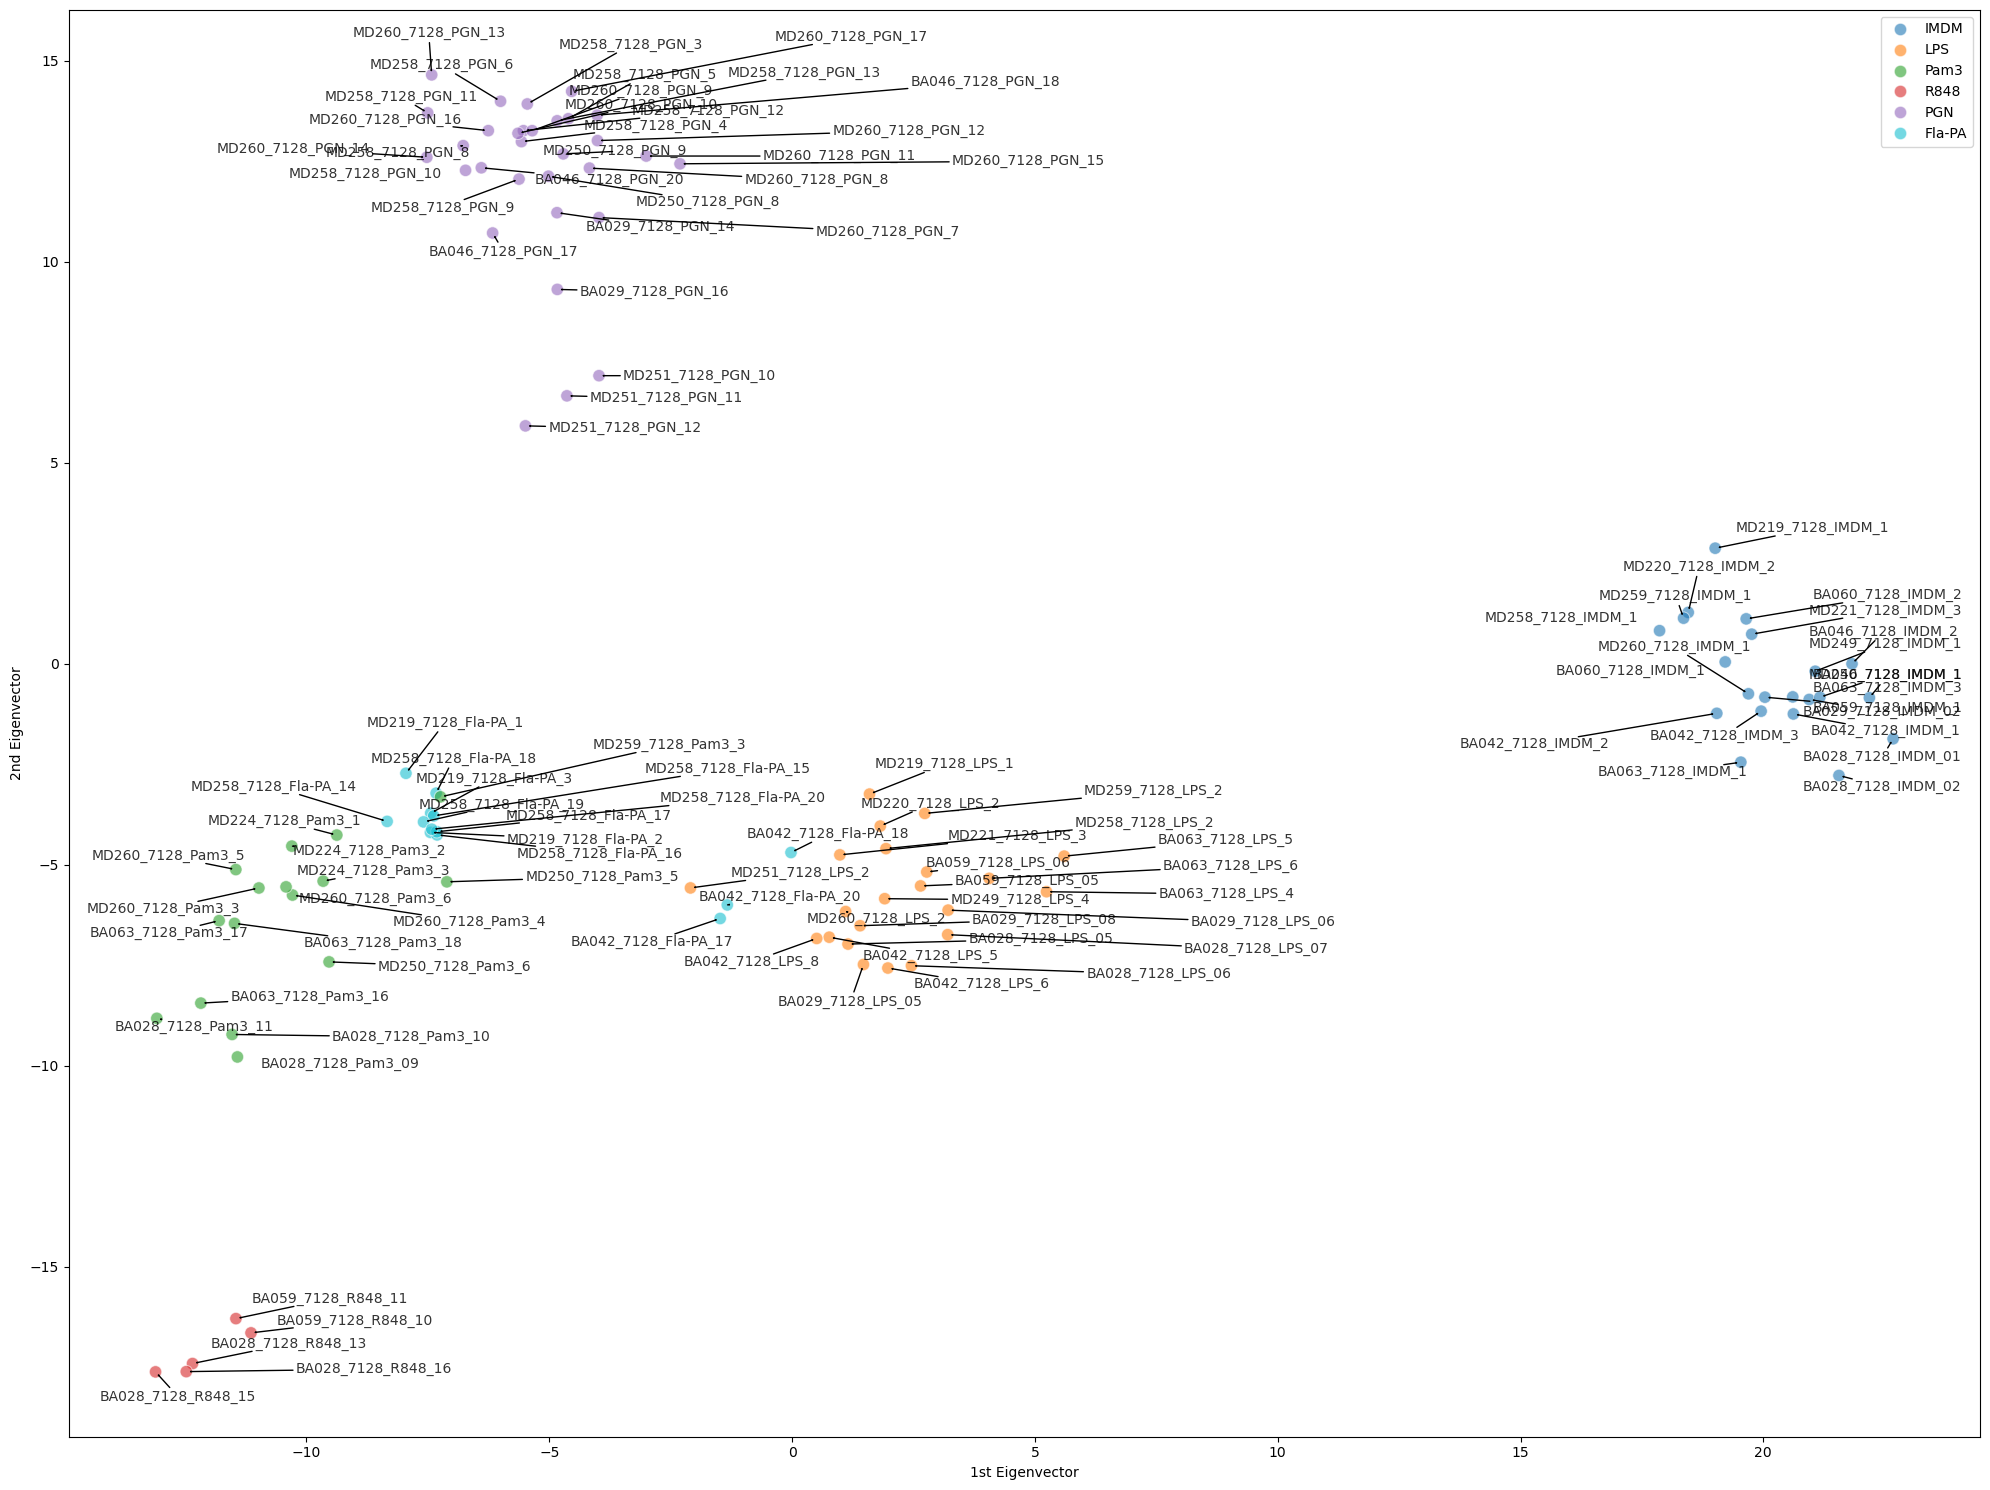

In [ ]:
processed_data = pipe.fit_transform(training_data, training_labels)
training_labels_int = le.fit_transform(training_labels["label"].to_numpy())


colors = [
    custom_palette_6[label % len(custom_palette_6)] for label in training_labels_int
]

fig = plt.figure(figsize=(20, 15))

X_reduced = PCA(n_components=2).fit_transform(processed_data)

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=training_labels["label"].to_numpy(),
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)
texts = [
    ax.text(
        X_reduced[:, 0][i],
        X_reduced[:, 1][i],
        training_labels.index.to_numpy()[i],
        ha="left",
        va="bottom",
        alpha=0.8,
    )
    for i in range(len(X_reduced))
]

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1)
plt.tight_layout()
plt.show()

### Training

In [128]:
sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X, y = sm.fit_resample(training_data, training_labels)
X = X.to_numpy()
y = le.transform(y)

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [123]:
svc = SVC(
    kernel="linear", probability=False, class_weight=None, random_state=random_state
)
svc = CalibratedClassifierCV(svc)

sgd = SGDClassifier(
    loss="modified_huber", early_stopping=True, random_state=random_state
)
rfc = RandomForestClassifier(
    max_depth=5, n_estimators=500, random_state=random_state, class_weight=None
)
bst = XGBClassifier(objective="multi:softmax", random_state=random_state)

models = {
    "LinearSVC": svc,
    "SGDClassifier": sgd,
    "RandomForestClassifier": rfc,
    "XGBClassifier": bst,
}

  0%|          | 0/4 [00:00<?, ?it/s]

Processing LinearSVC


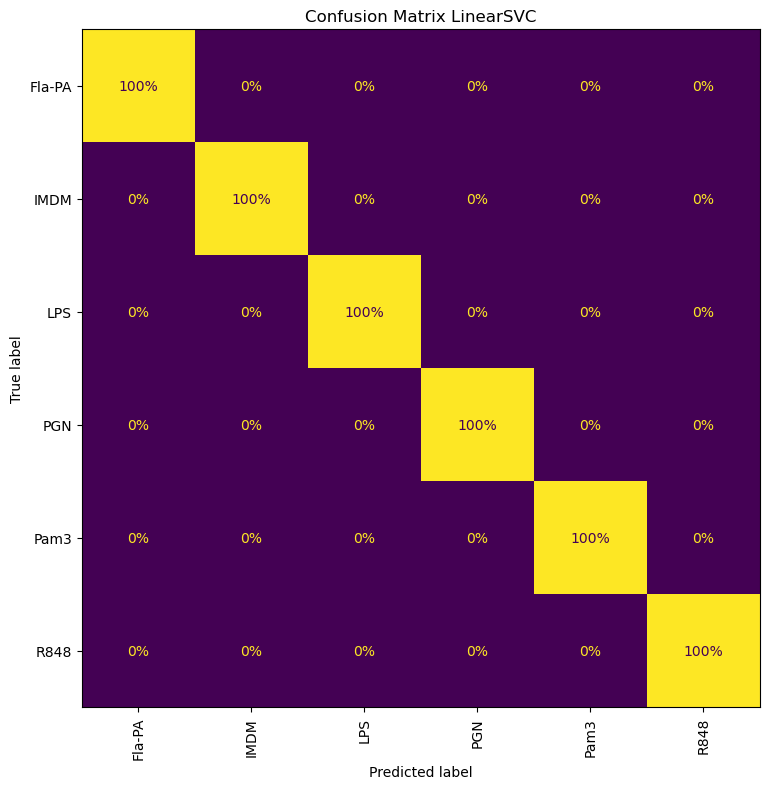

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         7
        IMDM       1.00      1.00      1.00         7
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



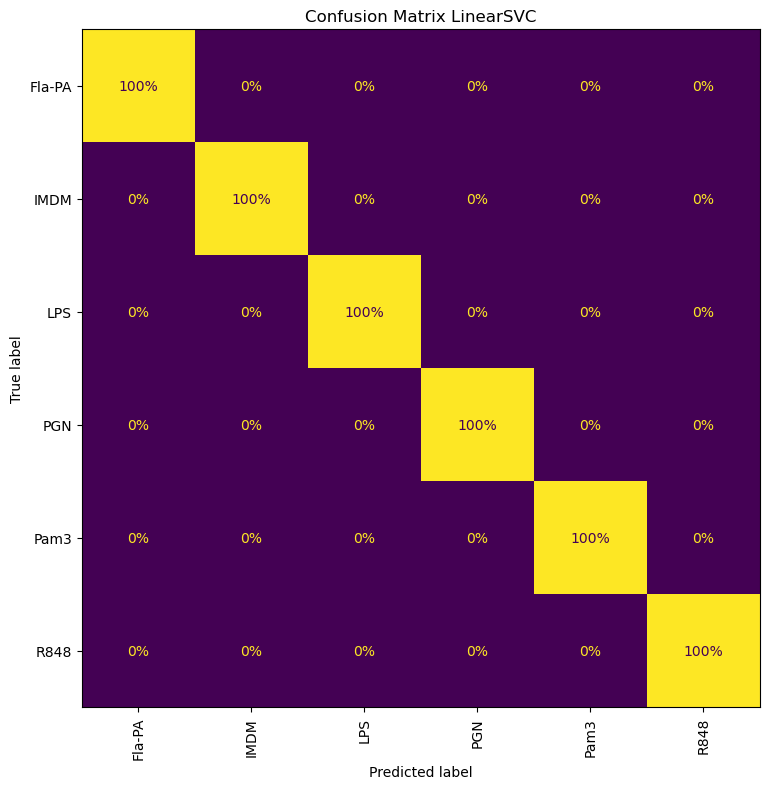

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         7
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



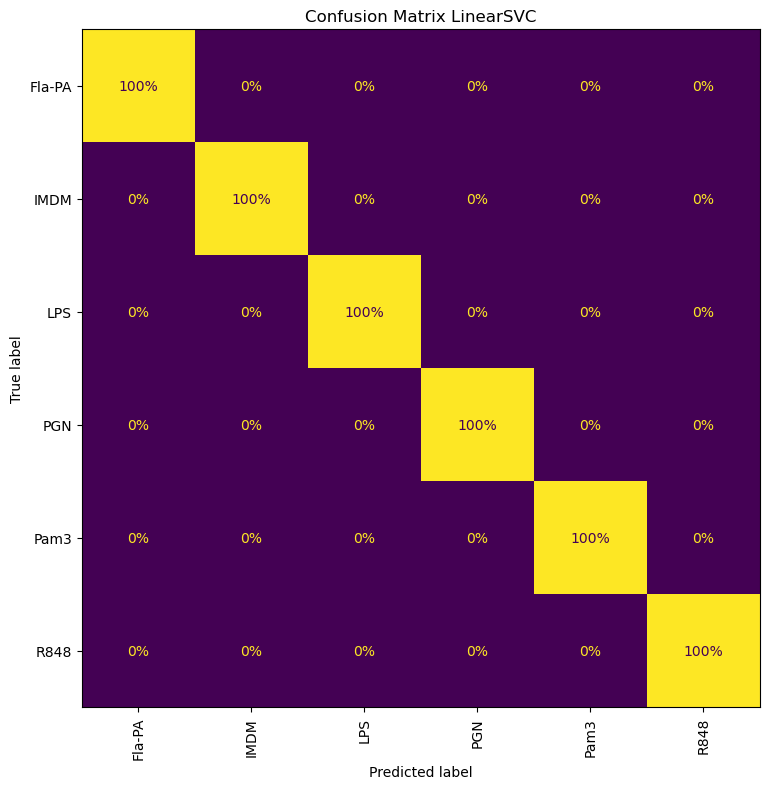

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         7
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



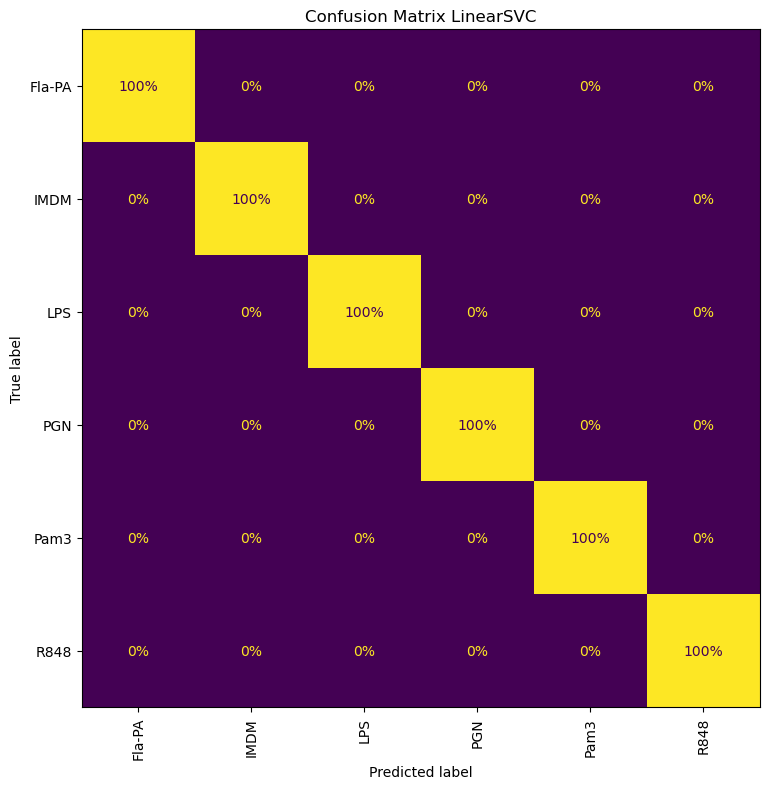

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         7

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



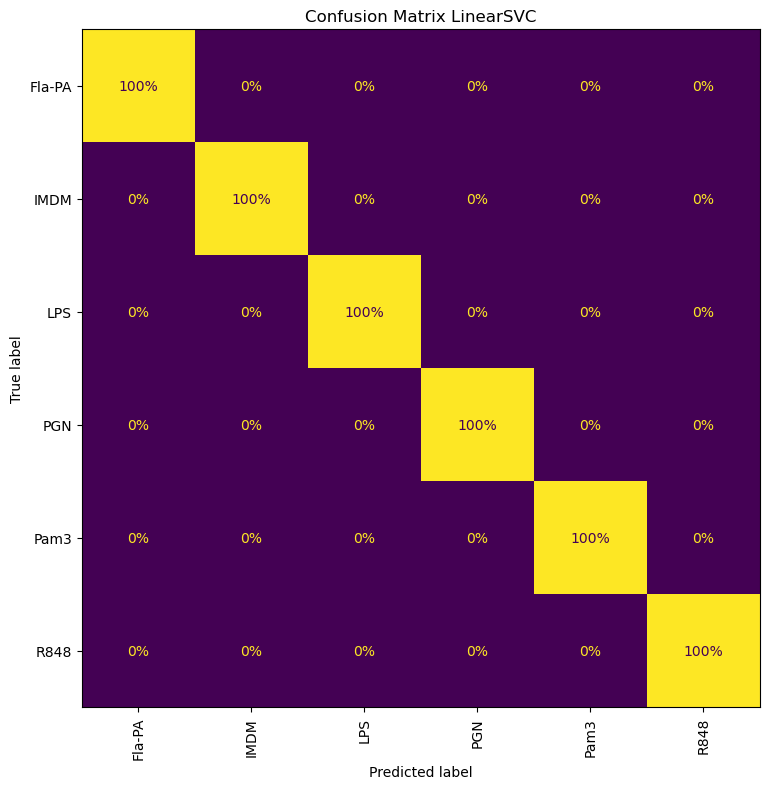

 25%|██▌       | 1/4 [00:41<02:04, 41.57s/it]

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Processing SGDClassifier


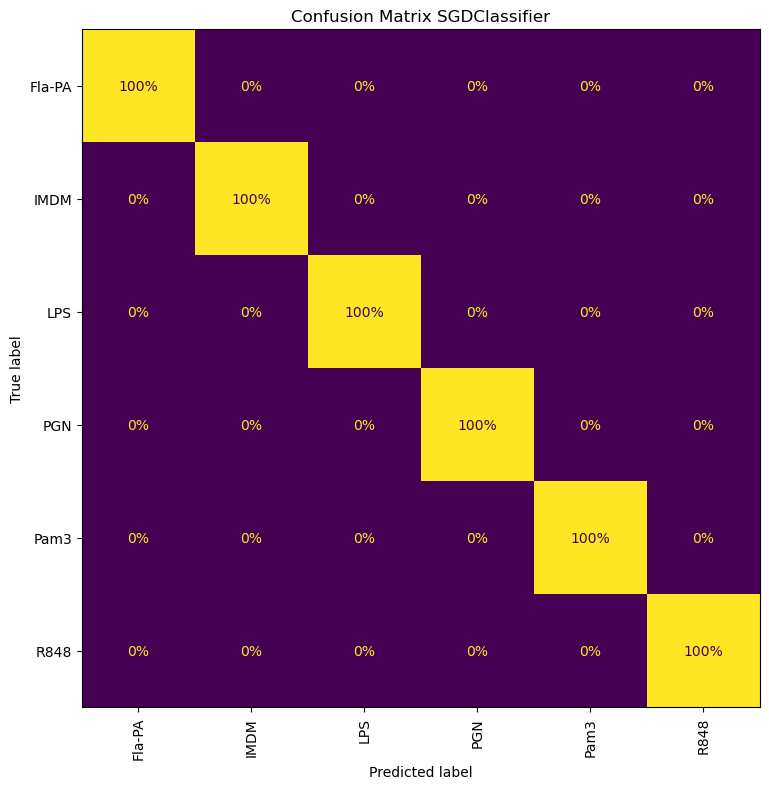

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         7
        IMDM       1.00      1.00      1.00         7
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



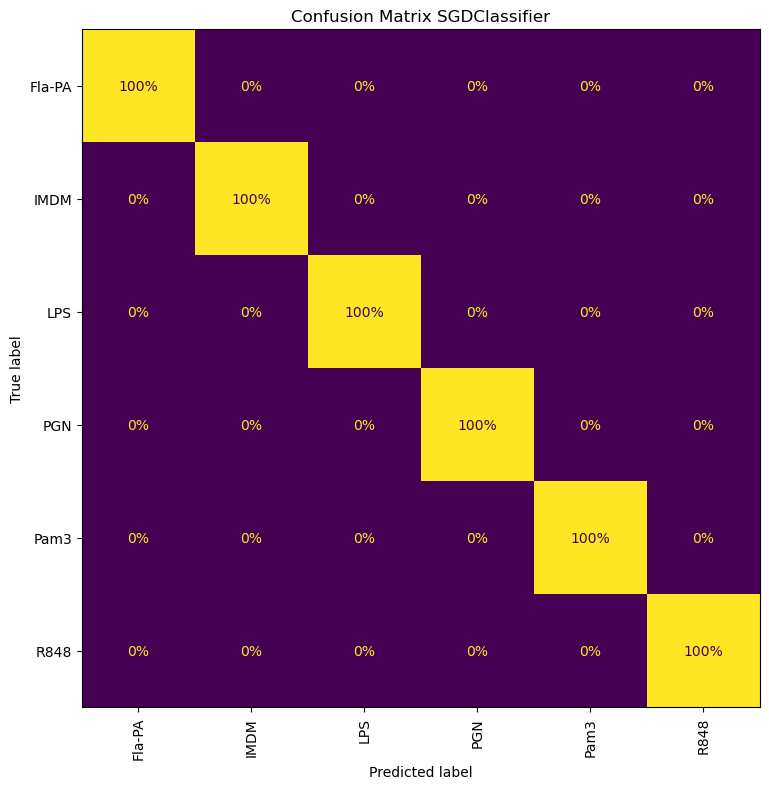

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         7
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



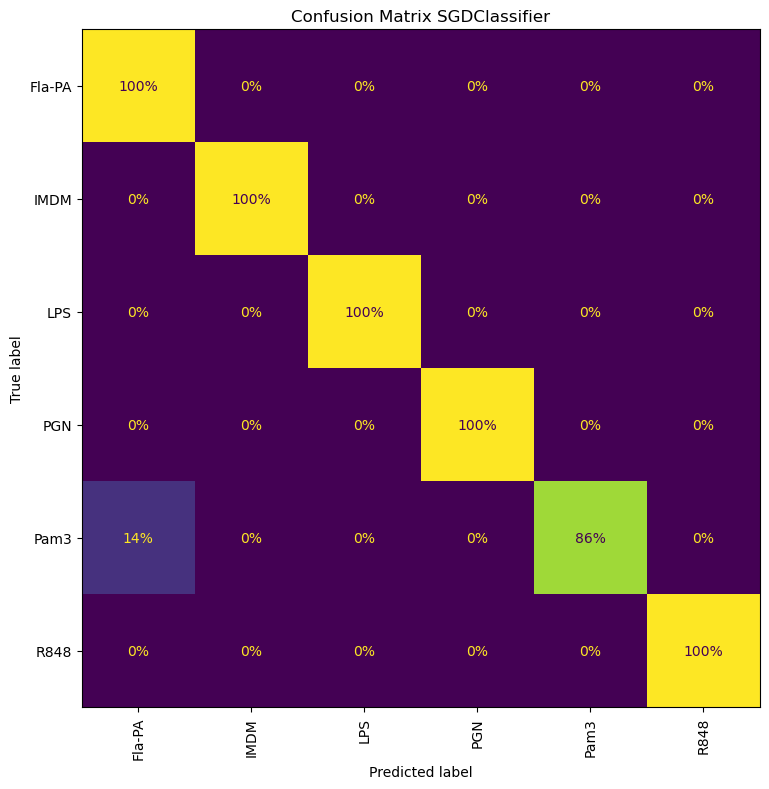

              precision    recall  f1-score   support

      Fla-PA       1.00      0.86      0.92         7
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       0.86      1.00      0.92         6
        R848       1.00      1.00      1.00         6

    accuracy                           0.97        37
   macro avg       0.98      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37



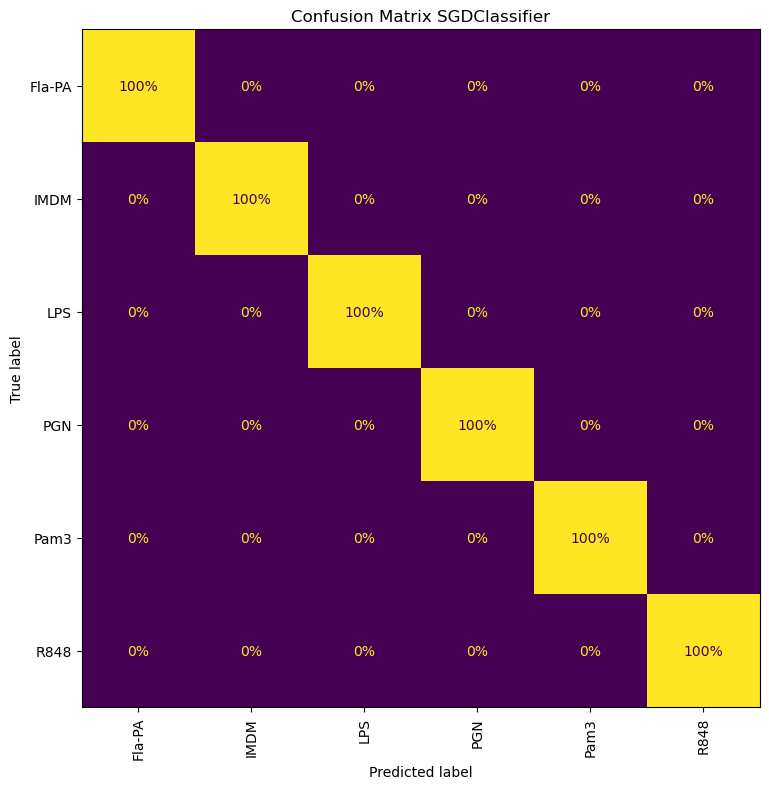

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         7

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



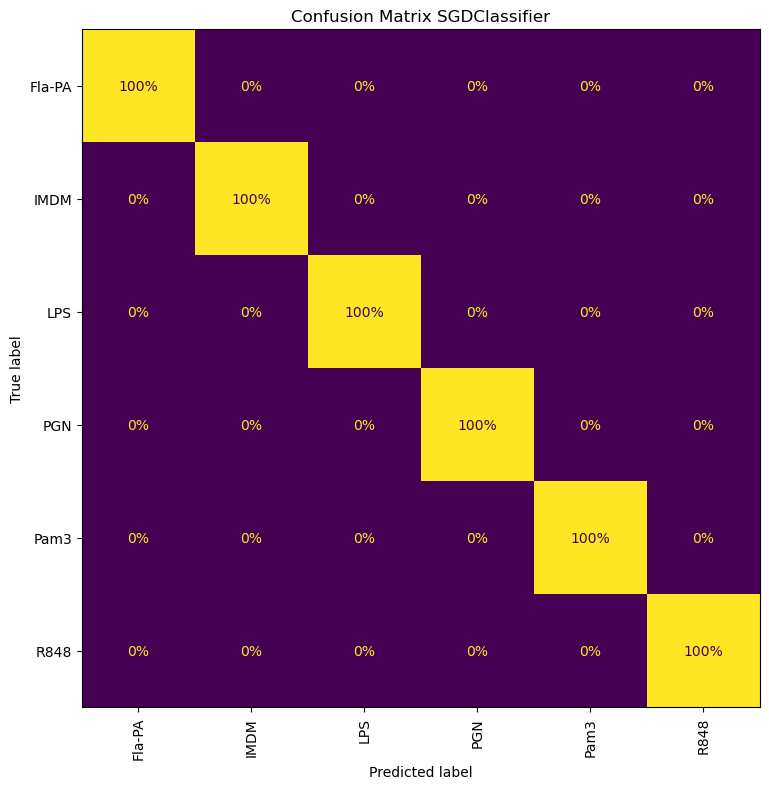

 50%|█████     | 2/4 [01:21<01:21, 40.66s/it]

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Processing RandomForestClassifier


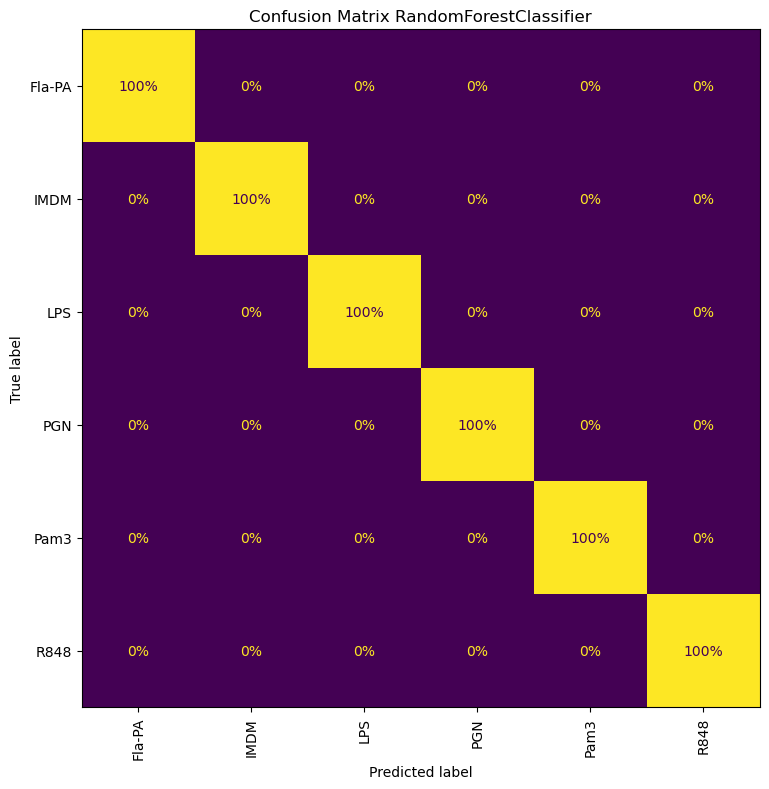

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         7
        IMDM       1.00      1.00      1.00         7
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



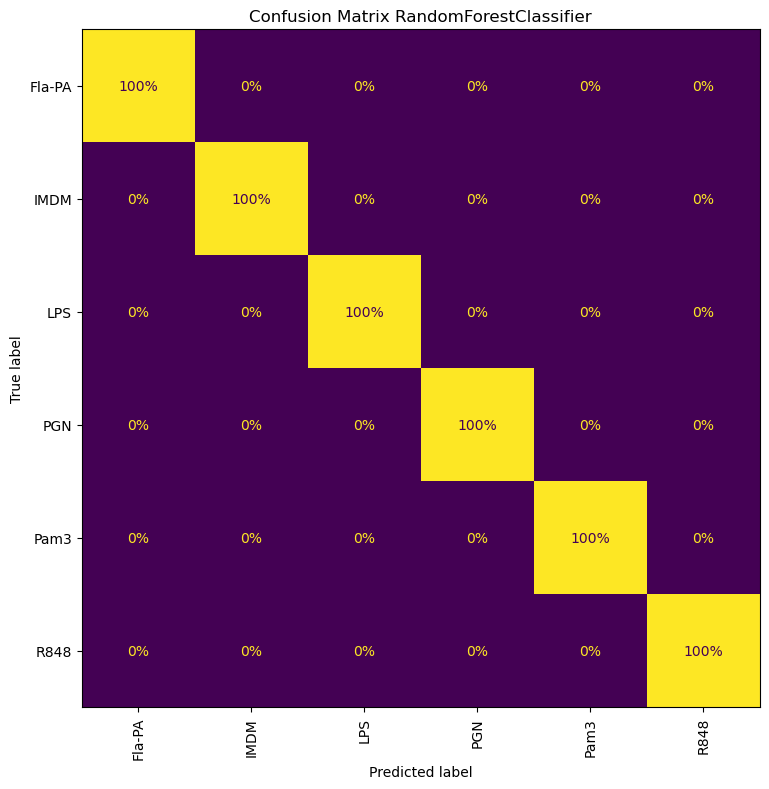

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         7
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



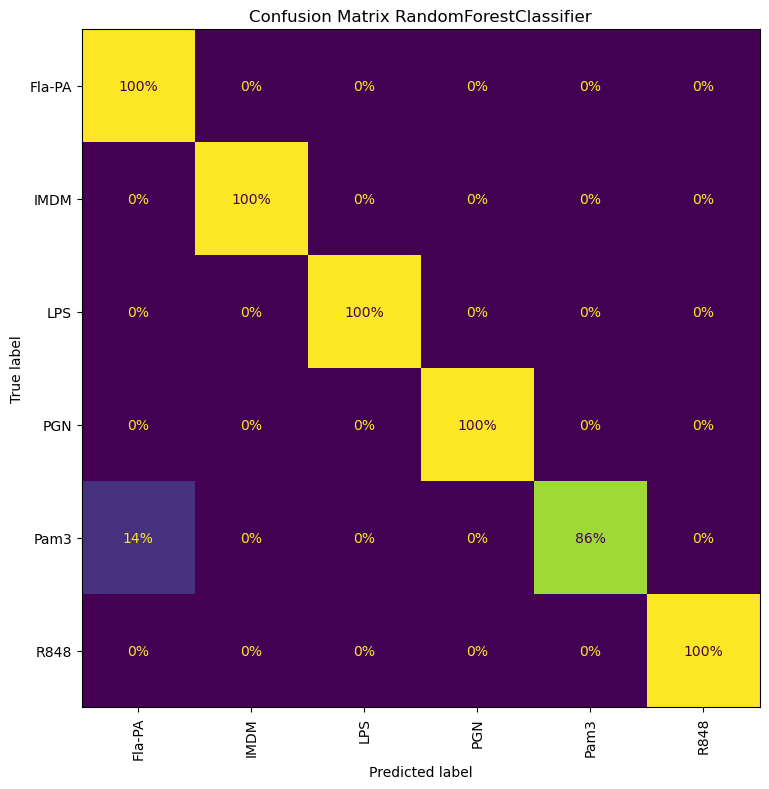

              precision    recall  f1-score   support

      Fla-PA       1.00      0.86      0.92         7
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       0.86      1.00      0.92         6
        R848       1.00      1.00      1.00         6

    accuracy                           0.97        37
   macro avg       0.98      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37



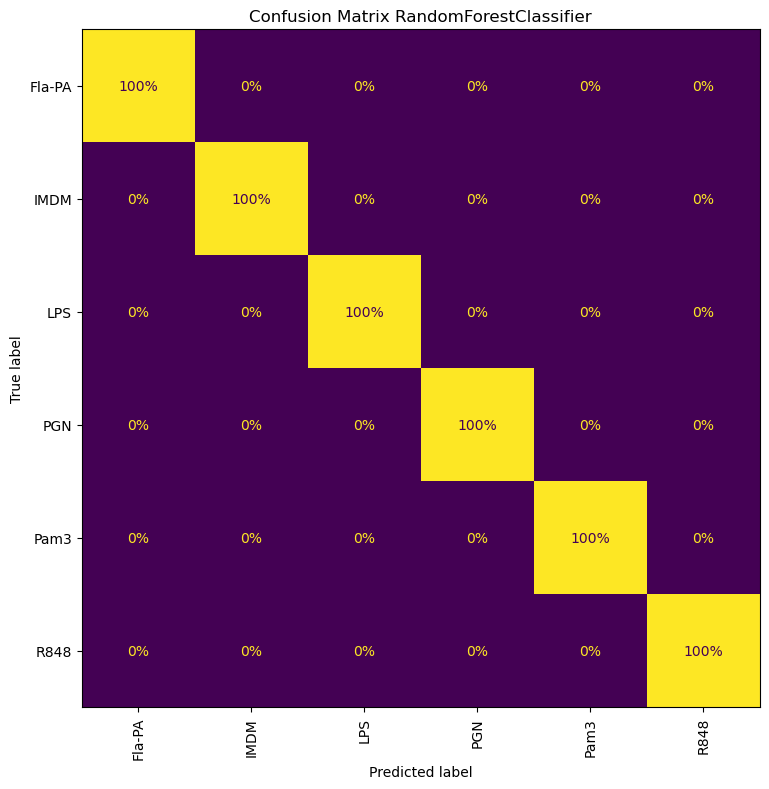

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         7

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



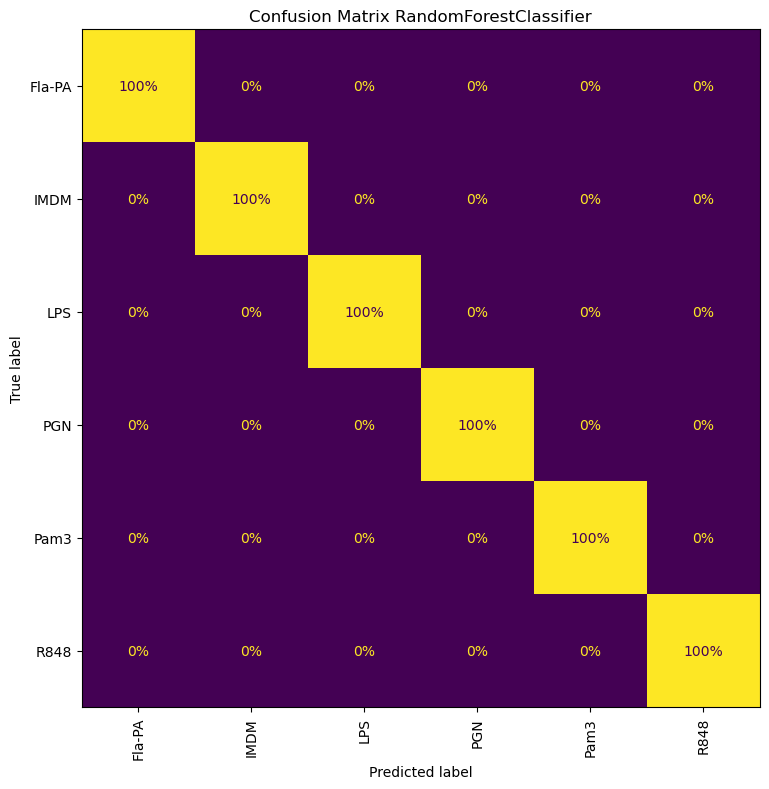

 75%|███████▌  | 3/4 [02:04<00:41, 41.79s/it]

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Processing XGBClassifier


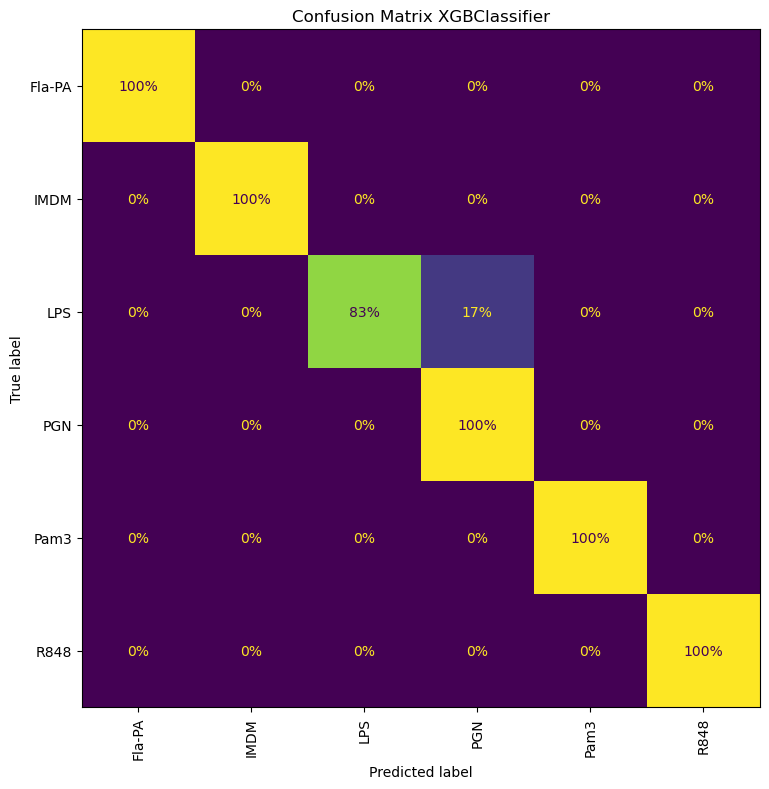

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         7
        IMDM       1.00      1.00      1.00         7
         LPS       0.83      1.00      0.91         5
         PGN       1.00      0.86      0.92         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



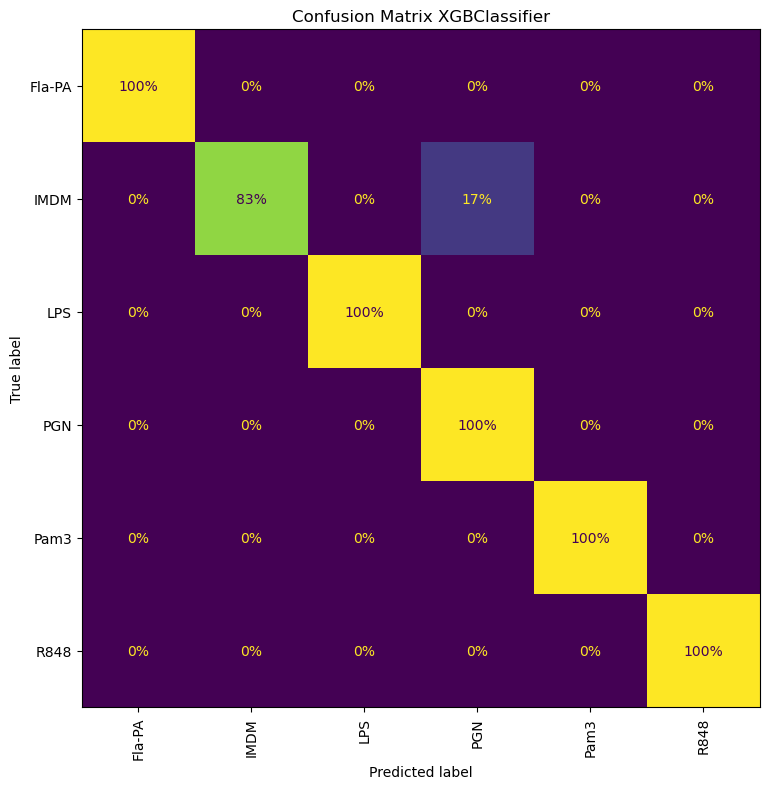

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       0.83      1.00      0.91         5
         LPS       1.00      1.00      1.00         7
         PGN       1.00      0.86      0.92         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37



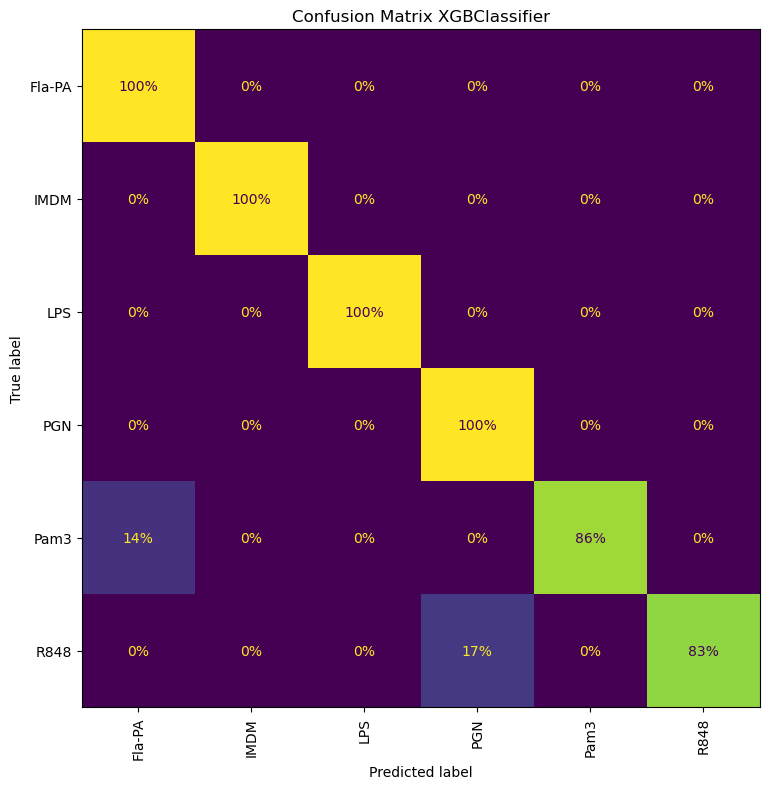

              precision    recall  f1-score   support

      Fla-PA       1.00      0.86      0.92         7
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      0.86      0.92         7
        Pam3       0.86      1.00      0.92         6
        R848       0.83      1.00      0.91         5

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37



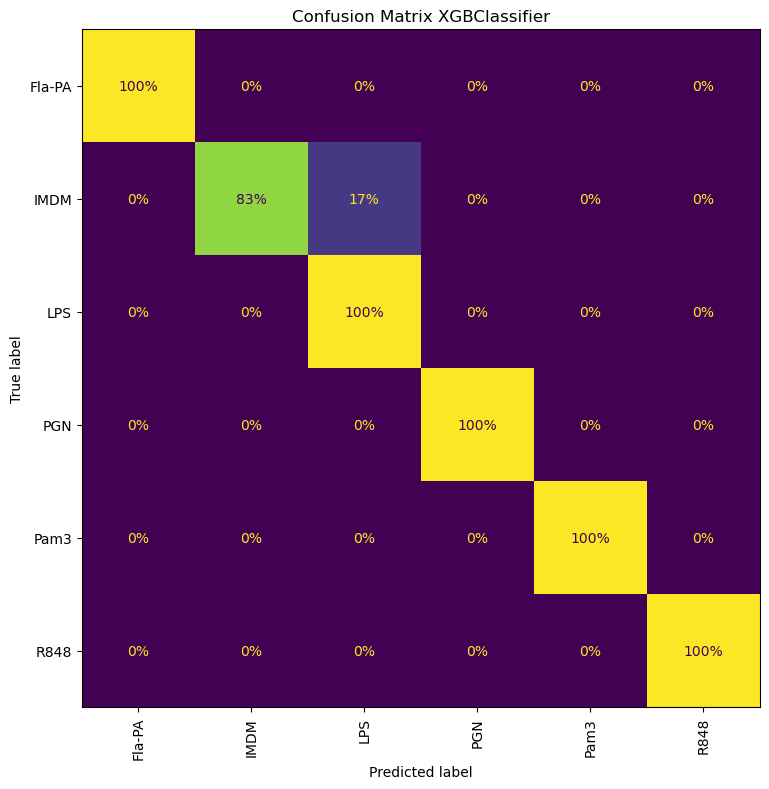

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       0.83      1.00      0.91         5
         LPS       1.00      0.86      0.92         7
         PGN       1.00      1.00      1.00         6
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         7

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37



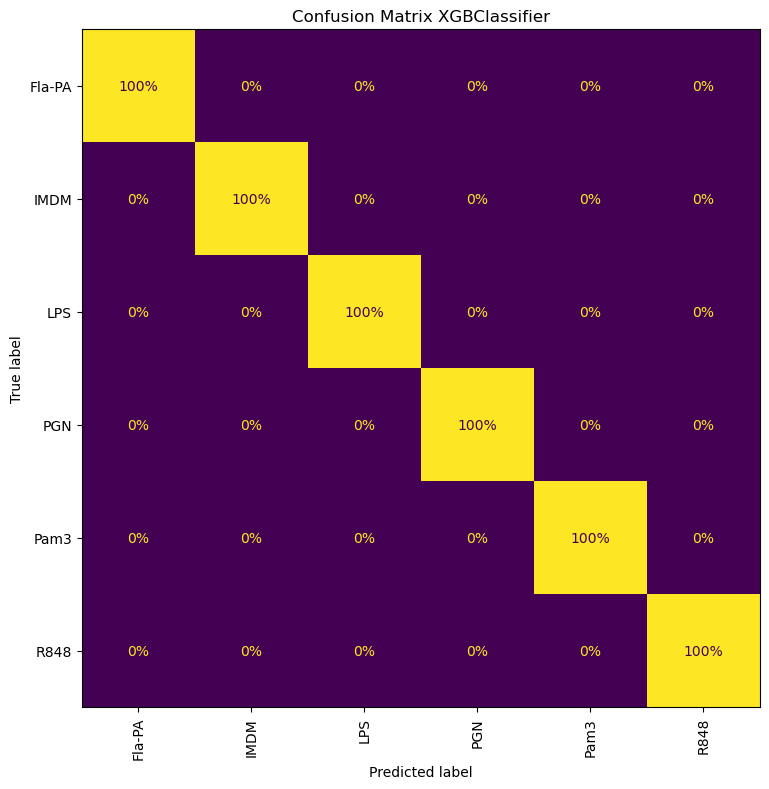

100%|██████████| 4/4 [06:05<00:00, 91.48s/it] 

              precision    recall  f1-score   support

      Fla-PA       1.00      1.00      1.00         6
        IMDM       1.00      1.00      1.00         6
         LPS       1.00      1.00      1.00         6
         PGN       1.00      1.00      1.00         7
        Pam3       1.00      1.00      1.00         6
        R848       1.00      1.00      1.00         6

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [136]:
CV = 5
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=93)

results = []
for model_name, model in tqdm(models.items()):
    print(f"Processing {model_name}")
    start_time = time.time()
    for fold_index, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipe.fit(X_train, y_train)
        X_train = pipe.transform(X_train)
        X_test = pipe.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        total_time = time.time() - start_time

        for score_name, score_value in make_score(y_test, y_pred):
            results.append(
                {
                    "fold": fold_index + 1,
                    "model": model_name,
                    "score_name": score_name,
                    "score_value": score_value,
                    "run_time": total_time,
                }
            )

        y_pred = le.inverse_transform(y_pred)
        y_test = le.inverse_transform(y_test)
        get_confusion_matrix(y_pred, y_test, model_name)
        print(classification_report(y_pred, y_test))

scores_per_model_7128 = pd.DataFrame(results)

In [ ]:
scores_per_model_7128.groupby(["model", "data", "score_name"]).agg("mean")[
    ["score_value", "run_time"]
].round(3)

TypeError: agg function failed [how->mean,dtype->object]